In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Chargement des données
df = pd.read_csv("/content/drive/MyDrive/projet_sta211/data/raw/data_train.csv", sep='\t')

# Nettoyage de la variable cible
df['outcome'] = df['outcome'].str.strip('.')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['outcome'])

# Variables explicatives
X = df.drop(columns=['outcome'])

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline d'imputation
imputer = SimpleImputer(strategy='median')

# Modèles avec pipelines
models = {
    'RandomForest': make_pipeline(imputer, RandomForestClassifier(random_state=42)),
    'LogisticRegression': make_pipeline(imputer, StandardScaler(), LogisticRegression(max_iter=1000, random_state=42)),
    'SVM': make_pipeline(imputer, StandardScaler(), SVC(random_state=42)),
    'NaiveBayes': make_pipeline(imputer, GaussianNB()),
    'KNN': make_pipeline(imputer, StandardScaler(), KNeighborsClassifier())
}

# Entraînement et évaluation
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='weighted')
    results[name] = f1
    print(f"{name} F1-score (weighted): {f1:.4f}")

# Affichage du meilleur modèle
best_model_name = max(results, key=results.get)
print(f"\n✅ Meilleur modèle : {best_model_name} avec un F1-score de {results[best_model_name]:.4f}")


RandomForest F1-score (weighted): 0.9771
LogisticRegression F1-score (weighted): 0.9540
SVM F1-score (weighted): 0.9615
NaiveBayes F1-score (weighted): 0.7903
KNN F1-score (weighted): 0.9498

✅ Meilleur modèle : RandomForest avec un F1-score de 0.9771


# Projet STA211 — Modélisation supervisée : Classification de publicités

# Table des matières

1. [Introduction](#1-introduction)
2. [Préparation de l'environnement](#2-preparation-de-lenvironnement)
3. [Chargement des bibliothèques](#3-chargement-des-bibliothèques)
4. [Chargement et préparation initiale des données](#4-chargement-et-préparation-initiale-des-données)
   - [4.1. Chargement des jeux de données](#41-chargement-des-jeux-de-données)
   - [4.2. Définition des variables X et y](#42-définition-des-variables-x-et-y)
5. [Construction du pipeline de prétraitement et d'équilibrage](#5-construction-du-pipeline-de-prétraitement-et-déquilibrage)
   - [5.1. Pipeline de prétraitement (Standardisation)](#51-pipeline-de-prétraitement-standardisation)
   - [5.2. Stratégie d'équilibrage des classes (par SMOTE)](#52-stratégie-déquilibrage-des-classes-par-smote)
6. [Évaluation comparative des modèles via optimisation](#6-évaluation-comparative-des-modèles-via-optimisation)
   - [6.1. Définition des modèles à évaluer](#61-définition-des-modèles-à-évaluer)
     - [6.1.1. Définition des hyperparamètres](#611-définition-des-hyperparamètres)
     - [6.1.2. Fonctions d'évaluation](#612-fonctions-dévaluation)
   - [6.2. Optimisation et évaluation des modèles](#62-optimisation-et-évaluation-des-modèles)
     - [6.2.1. Évaluation sur données KNN](#621-évaluation-sur-données-knn)
     - [6.2.2. Évaluation sur données MICE](#622-évaluation-sur-données-mice)
     - [6.2.3. Comparaison des résultats](#623-comparaison-des-résultats)
7. [Optimisation du seuil de décision pour le F1-score](#7-optimisation-du-seuil)
8. [Stacking optimisé](#8-stacking-optimisé)
   - [8.1. Principe du stacking](#81-principe-du-stacking)
   - [8.2. Implémentation modulaire](#82-implémentation-modulaire)
9. [Sélection de variables et étude d'impact](#9-sélection-de-variables-et-étude-dimpact)
   - [9.1. Permutation Importance](#91-permutation-importance-sur-les-meilleurs-modèles-optimisés)
   - [9.2. Étude d'ablation](#92-étude-dablation--f1-score-vs-nombre-de-variables)
   - [9.3. Réentraînement sur variables optimales](#93-réentraînement-sur-variables-optimales)
10. [Génération des prédictions finales](#10-génération-des-prédictions-finales)
11. [Conclusion et perspectives](#11-conclusion-et-perspectives)

# 1. Introduction <a id="1-introduction"></a>

Ce notebook s’inscrit dans le cadre du cours **STA211** du CNAM et constitue la **phase de modélisation supervisée** du projet de classification de publicités sur internet.  
Il fait suite à l’analyse exploratoire et au prétraitement réalisés dans le notebook `01_EDA_Preprocessing.ipynb`.

### 🎯 Objectif

L'objectif est de développer un modèle prédictif capable de **classifier automatiquement** une observation comme étant une **publicité (`ad.`)** ou **non (`noad.`)**, à partir des variables du dataset **Internet Advertisements**.  
L’évaluation repose principalement sur **l’optimisation du F1-score**, compte tenu du **déséquilibre de classes** entre les publicités et les non-publicités.

### 📁 Fichiers utilisés

- `final_dataset_knn_no_outliers.parquet` : données d'entraînement prétraitées et imputées par KNN, sans outliers.
- `final_dataset_mice_no_outliers.parquet` : version alternative avec imputation multiple (MICE), sans outliers.
- `data_test.csv` : jeu de données de test à prédire (sans la variable `outcome`).

> **Note** : Les versions avec outliers (`_with_outliers`) sont disponibles mais non utilisées dans ce notebook, car les données sans outliers ont été privilégiées pour la modélisation.

### Étapes couvertes

1. **Préparation des données pour la modélisation** :
   - Séparation en ensembles d'entraînement et de test (80/20),
   - Équilibrage des classes par **SMOTE** (Synthetic Minority Over-sampling Technique),
   - Transformation des variables continues avec **Yeo-Johnson**,
   - Standardisation des variables avec `StandardScaler`.

2. **Implémentation de modèles supervisés** :
   - Régression logistique,
   - Arbres de décision (CART),
   - Forêts aléatoires,
   - K-Plus Proches Voisins (KNN),
   - Machines à vecteurs de support (SVM),
   - Réseaux de neurones (MLP),
   - Modèles de boosting (LightGBM, XGBoost),
   - Stacking de modèles pour combiner leurs prédictions.

3. **Évaluation comparative des performances** :
   - Métriques : F1-score, précision, rappel, AUC,
   - Validation croisée à 5 plis pour une évaluation robuste,
   - Analyse des matrices de confusion.

4. **Génération des prédictions finales** :
   - Production d’un fichier `my_pred.csv` pour la **soumission automatique**,
   - Format : 820 lignes avec deux colonnes (`id`, `label`), où `label` prend les valeurs `ad.` ou `noad.`.

# 2. Préparation de l'environnement <a id="2-preparation-de-lenvironnement"></a>

Cette section configure l'environnement d'exécution pour la modélisation supervisée du projet STA211. Elle inclut :
- La détection de l'environnement (Google Colab ou local),
- Le montage de Google Drive pour Colab,
- L'installation des dépendances via `requirements.txt`,
- La configuration des chemins pour les données, modules, modèles, et figures,
- La configuration des options d'affichage de pandas,
- L'affichage des versions de pandas et IPython pour garantir la reproductibilité.

> **Prérequis** : Placez le fichier `requirements.txt` dans `/content/drive/MyDrive/projet_sta211` pour Colab ou dans le répertoire racine local. Assurez-vous que le dossier `projet_sta211` est accessible.

In [5]:
# 2. Préparation de l'environnement <a id="2-preparation-de-lenvironnement"></a>

# ============================================================================
# IMPORTS SYSTÈME ET CONFIGURATION DE BASE
# ============================================================================

import sys
import os
import warnings
import logging
from pathlib import Path
from IPython.display import Markdown, display
import pandas as pd
import IPython

# Configuration du logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
logger = logging.getLogger(__name__)

# Suppression des avertissements non critiques
warnings.filterwarnings("ignore", category=UserWarning)

# Configuration pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.precision', 4)
logger.info("Configuration pandas appliquée")

# ============================================================================
# DÉTECTION ET CONFIGURATION DE L'ENVIRONNEMENT
# ============================================================================

def is_colab():
    """Détecte si le code s'exécute dans Google Colab."""
    try:
        import google.colab
        return True
    except ImportError:
        return False

def setup_environment():
    """Configure l'environnement selon le type détecté."""
    env = "colab" if is_colab() else "local"
    logger.info(f"Environnement détecté : {env}")

    if env == "colab":
        try:
            from google.colab import drive
            logger.info("Montage de Google Drive...")
            drive.mount('/content/drive', force_remount=True)
            logger.info("Google Drive monté avec succès")
            # Installation des dépendances
            requirements_path = Path("/content/drive/MyDrive/projet_sta211/requirements.txt")
            if requirements_path.exists():
                logger.info("Installation des dépendances dans Colab...")
                import subprocess
                subprocess.run(["pip", "install", "-r", str(requirements_path)], check=True)
                logger.info("Dépendances installées avec succès")
            else:
                logger.error(f"Fichier requirements.txt introuvable : {requirements_path}")
                raise FileNotFoundError(f"❌ Fichier requirements.txt introuvable : {requirements_path}")
        except Exception as e:
            logger.error(f"Échec du montage de Drive ou de l'installation : {e}")
            raise
    return env

ENV = setup_environment()

# ============================================================================
# AFFICHAGE DES VERSIONS DES BIBLIOTHÈQUES
# ============================================================================

def display_library_versions():
    versions = {
        "pandas": pd.__version__,
        "ipython": IPython.__version__
    }
    versions_md = "\n".join([f"- `{k}`: {v}" for k, v in versions.items()])
    display(Markdown(f"### Versions des bibliothèques\n{versions_md}"))
display_library_versions()

# ============================================================================
# CONFIGURATION DES CHEMINS ET MODULES
# ============================================================================

def configure_module_paths(env):
    """Configure les chemins des modules selon l'environnement."""
    if env == "colab":
        module_path = Path("/content/drive/MyDrive/projet_sta211/modules")
    else:
        module_path = Path(os.getenv("STA211_PROJECT_PATH", "G:/Mon Drive/projet_sta211")) / "modules"

    if not module_path.exists():
        logger.error(f"Dossier des modules introuvable : {module_path}")
        raise FileNotFoundError(f"❌ Dossier des modules introuvable : {module_path}")

    if str(module_path) not in sys.path:
        sys.path.insert(0, str(module_path))
        logger.info(f"Chemin ajouté au sys.path : {module_path}")
    else:
        logger.info(f"Module path déjà configuré : {module_path}")

    return module_path

def load_project_paths(env):
    """Charge la configuration des chemins du projet."""
    try:
        from project_setup import setup_project_paths
        paths = setup_project_paths()
        logger.info("Configuration des chemins réussie")
        return paths
    except ImportError as e:
        logger.error(f"Échec de l'importation de setup_project_paths : {e}")
        raise

module_path = configure_module_paths(ENV)
paths = load_project_paths(ENV)

# ============================================================================
# CRÉATION DES DOSSIERS SPÉCIFIQUES À LA MODÉLISATION
# ============================================================================

FIGURES_MODELING_DIR = paths["FIGURES_DIR"] / "modeling"
FIGURES_MODELING_DIR.mkdir(parents=True, exist_ok=True)
paths["FIGURES_MODELING_DIR"] = FIGURES_MODELING_DIR
logger.info(f"Dossier créé ou vérifié : {FIGURES_MODELING_DIR}")

THRESHOLDS_DIR = paths["ROOT_DIR"] / "outputs" / "modeling" / "thresholds"
THRESHOLDS_DIR.mkdir(parents=True, exist_ok=True)
paths["THRESHOLDS_DIR"] = THRESHOLDS_DIR
logger.info(f"Dossier créé ou vérifié : {THRESHOLDS_DIR}")

# ============================================================================
# AFFICHAGE DES CHEMINS
# ============================================================================

def display_paths():
    paths_md = f"""
| Nom du dossier           | Chemin configuré                              |
|--------------------------|-----------------------------------------------|
| `ROOT_DIR`               | `{paths["ROOT_DIR"]}`                         |
| `MODULE_DIR`             | `{paths["MODULE_DIR"]}`                       |
| `RAW_DATA_DIR`           | `{paths["RAW_DATA_DIR"]}`                     |
| `DATA_PROCESSED`         | `{paths["DATA_PROCESSED"]}`                   |
| `MODELS_DIR`             | `{paths["MODELS_DIR"]}`                       |
| `FIGURES_DIR`            | `{paths["FIGURES_DIR"]}`                      |
| `FIGURES_MODELING_DIR`   | `{paths["FIGURES_MODELING_DIR"]}`             |
| `THRESHOLDS_DIR`         | `{paths["THRESHOLDS_DIR"]}`                   |
"""
    display(Markdown(paths_md))

display_paths()

# ============================================================================
# VALIDATION FINALE
# ============================================================================

logger.info("Configuration de l'environnement terminée avec succès")

Mounted at /content/drive


### Versions des bibliothèques
- `pandas`: 2.2.2
- `ipython`: 7.34.0


| Nom du dossier           | Chemin configuré                              |
|--------------------------|-----------------------------------------------|
| `ROOT_DIR`               | `/content/drive/MyDrive/projet_sta211`                         |
| `MODULE_DIR`             | `/content/drive/MyDrive/projet_sta211/modules`                       |
| `RAW_DATA_DIR`           | `/content/drive/MyDrive/projet_sta211/data/raw`                     |
| `DATA_PROCESSED`         | `/content/drive/MyDrive/projet_sta211/data/processed`                   |
| `MODELS_DIR`             | `/content/drive/MyDrive/projet_sta211/models`                       |
| `FIGURES_DIR`            | `/content/drive/MyDrive/projet_sta211/outputs/figures`                      |
| `FIGURES_MODELING_DIR`   | `/content/drive/MyDrive/projet_sta211/outputs/figures/modeling`             |
| `THRESHOLDS_DIR`         | `/content/drive/MyDrive/projet_sta211/outputs/modeling/thresholds`                   |


# 3. Chargement des bibliothèques <a id="3-chargement-des-bibliothèques"></a>

Cette section importe toutes les bibliothèques nécessaires à la modélisation supervisée via le module `imports_sta211.py`. Les bibliothèques incluent :

- Le traitement des données (`pandas`, `numpy`),
- La visualisation (`matplotlib`, `seaborn`),
- La modélisation supervisée (`scikit-learn`, `xgboost`, `lightgbm`),
- Le traitement du déséquilibre des classes (`imblearn`),
- Des utilitaires pour le suivi des progrès (`tqdm`).

Les configurations d'affichage (pandas) et graphiques (matplotlib, seaborn) sont définies dans `imports_sta211.py` pour optimiser la lisibilité des résultats. Les versions des bibliothèques sont affichées pour garantir la reproductibilité.

In [10]:
# 3. Chargement des bibliothèques <a id="3-chargement-des-bibliothèques"></a>

# ============================================================================
# IMPORT DES BIBLIOTHÈQUES VIA imports_sta211
# ============================================================================

from imports_sta211 import *
logger.info("Bibliothèques importées depuis imports_sta211")

# ============================================================================
# AFFICHAGE DES VERSIONS DES BIBLIOTHÈQUES DE MODÉLISATION
# ============================================================================

def display_modeling_library_versions():
    versions = {
        "pandas": pd.__version__,
        "numpy": np.__version__,
        "scikit-learn": sklearn.__version__,
        "imbalanced-learn": imblearn.__version__,
        "xgboost": xgb.__version__,
        "lightgbm": lgb.__version__,
        "matplotlib": matplotlib.__version__,
        "seaborn": sns.__version__,
        "scipy": scipy.__version__,
        "joblib": joblib.__version__,
        "tqdm": __import__("tqdm").__version__
    }
    versions_md = "\n".join([f"- `{k}`: {v}" for k, v in versions.items()])
    display(Markdown(f"### Versions des bibliothèques de modélisation\n{versions_md}"))

display_modeling_library_versions()

logger.info("Chargement des bibliothèques terminé")

### Versions des bibliothèques de modélisation
- `pandas`: 2.2.2
- `numpy`: 2.0.2
- `scikit-learn`: 1.6.1
- `imbalanced-learn`: 0.13.0
- `xgboost`: 2.1.4
- `lightgbm`: 4.5.0
- `matplotlib`: 3.10.0
- `seaborn`: 0.13.2
- `scipy`: 1.15.3
- `joblib`: 1.5.1
- `tqdm`: 4.67.1

<a name="4-chargement-et-préparation-initiale-des-données"></a>
# 4. Chargement et préparation initiale des données

Cette section vise à charger les données traitées depuis le dossier `data/processed`, puis à préparer les objets `X` et `y` qui seront utilisés dans les étapes de modélisation.

## 4.1 Chargement des jeux de données <a id = "4.1-Chargement-des-jeux-de-données"></a>

Les deux jeux de données d'entraînement disponibles sont issus de deux stratégies d'imputation :
- `df_knn` : imputation par **KNN**
- `df_mice` : imputation **multiple** via MICE

Les deux sont analysés puis utilisés pour entraîner et comparer différents modèles supervisés.

In [13]:
# === 4.1. Chargement des datasets issus de l’EDA (version interactive) ===
import pandas as pd
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, Markdown

# Récupération du chemin configuré
DATA_PROCESSED = paths["DATA_PROCESSED"]

# Chargement des 4 versions finales du dataset
AVAILABLE_DATAFRAMES = {
    'mice_with_outliers': pd.read_parquet(DATA_PROCESSED / "final_dataset_mice_with_outliers.parquet"),
    'mice_no_outliers': pd.read_parquet(DATA_PROCESSED / "final_dataset_mice_no_outliers.parquet"),
    'knn_with_outliers': pd.read_parquet(DATA_PROCESSED / "final_dataset_knn_with_outliers.parquet"),
    'knn_no_outliers': pd.read_parquet(DATA_PROCESSED / "final_dataset_knn_no_outliers.parquet")
}
# 🔍 Affichage de la distribution de la variable cible
for name, df in AVAILABLE_DATAFRAMES.items():
    if 'outcome' in df.columns:
        print(f"📊 {name} :")
        print(df['outcome'].value_counts(normalize=True), "\n")

# Fonction utilitaire pour charger un dataset par nom
def load_selected_dataset(name: str) -> pd.DataFrame:
    """Charge et retourne le DataFrame correspondant au nom sélectionné."""
    df = AVAILABLE_DATAFRAMES.get(name)
    if df is not None:
        print(f"✅ Dataset '{name}' chargé avec succès : shape = {df.shape}")
    else:
        print(f"❌ Dataset '{name}' introuvable.")
    return df

# Menu déroulant interactif
dropdown = widgets.Dropdown(
    options=list(AVAILABLE_DATAFRAMES.keys()),
    value='mice_with_outliers',
    description='Dataset :',
    style={'description_width': 'initial'}
)

output = widgets.Output()

def on_selection_change(change):
    with output:
        output.clear_output()
        df = load_selected_dataset(change['new'])
        display(df.head())

dropdown.observe(on_selection_change, names='value')

display(Markdown("### 📂 Sélectionnez un dataset pour l'explorer :"))
display(dropdown, output)


df_knn = load_selected_dataset("knn_no_outliers")
df_mice = load_selected_dataset("mice_no_outliers")


📊 mice_with_outliers :
outcome
0   0.8601
1   0.1399
Name: proportion, dtype: float64 

📊 mice_no_outliers :
outcome
0   0.9078
1   0.0922
Name: proportion, dtype: float64 

📊 knn_with_outliers :
outcome
0   0.8601
1   0.1399
Name: proportion, dtype: float64 

📊 knn_no_outliers :
outcome
0   0.9072
1   0.0928
Name: proportion, dtype: float64 



### 📂 Sélectionnez un dataset pour l'explorer :

Dropdown(description='Dataset :', options=('mice_with_outliers', 'mice_no_outliers', 'knn_with_outliers', 'knn…

Output()

✅ Dataset 'knn_no_outliers' chargé avec succès : shape = (1885, 655)
✅ Dataset 'mice_no_outliers' chargé avec succès : shape = (1899, 655)


<a name="42-définition-des-variables-x-et-y"></a>
## 4.2. Définition des variables X et y
Nous séparons ici la variable cible (`outcome`) des variables explicatives.  
La variable `outcome` est encodée en binaire (`1` pour "ad.", `0` pour "noad.").

Ensuite, les données sont divisées en ensembles d'entraînement et de test selon une répartition 80/20, avec stratification pour préserver la distribution de la variable cible.

Enfin, nous sauvegardons la liste des colonnes utilisées dans le jeu d'entraînement, ce qui facilitera les prédictions finales.

> **Remarque :**
> - “test” ici désigne le split interne issu de `data_train.csv`, utilisé pour l'évaluation locale des modèles.
> - Le vrai `data_test.csv` (sans colonne cible) est utilisé uniquement lors de la soumission finale.

In [14]:
# === 4.2. Définition des variables explicatives (X) et de la cible (y) ===

from sklearn.model_selection import train_test_split
import joblib
from IPython.display import Markdown

def split_and_save_features(X, y, name, models_dir=paths["MODELS_DIR"]):
    """
    Sépare X et y en train/test (80/20 stratifié), sauvegarde les colonnes utilisées, et retourne les splits.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    columns_used = X_train.columns.tolist()
    joblib.dump(columns_used, models_dir / f"columns_{name}_used.pkl")
    return X_train, X_test, y_train, y_test, columns_used

# === Chargement des X et y pour chaque dataset ===

# KNN
X_knn = df_knn.drop(columns=["outcome"])
y_knn = df_knn["outcome"].astype(int)

X_train_knn, X_test_knn, y_train_knn, y_test_knn, columns_knn_used = split_and_save_features(X_knn, y_knn, "knn")

print("✅ KNN - Répartition y_train :", y_train_knn.value_counts(normalize=True).to_dict())

# MICE
X_mice = df_mice.drop(columns=["outcome"])
y_mice = df_mice["outcome"].astype(int)

X_train_mice, X_test_mice, y_train_mice, y_test_mice, columns_mice_used = split_and_save_features(X_mice, y_mice, "mice")

print("✅ MICE - Répartition y_train :", y_train_mice.value_counts(normalize=True).to_dict())

# === Organisation des splits pour un accès plus simple plus tard ===
splits = {
    "knn": {
        "X_train": X_train_knn, "X_test": X_test_knn,
        "y_train": y_train_knn, "y_test": y_test_knn
    },
    "mice": {
        "X_train": X_train_mice, "X_test": X_test_mice,
        "y_train": y_train_mice, "y_test": y_test_mice
    }
}

# === Résumé des colonnes utilisées et des tailles ===
def print_split_summary():
    n_col_knn = len(columns_knn_used)
    n_col_mice = len(columns_mice_used)
    identical = set(columns_knn_used) == set(columns_mice_used)
    summary_md = f"""
### ✅ Résumé des colonnes utilisées

- **Colonnes KNN**  : {n_col_knn}
- **Colonnes MICE** : {n_col_mice}
- **Colonnes identiques** : {'✅ Oui' if identical else '❌ Non'}

### 📊 Dimensions des jeux d'entraînement

- `X_train_knn` : {X_train_knn.shape}
- `y_train_knn` : {y_train_knn.shape}
- `X_train_mice` : {X_train_mice.shape}
- `y_train_mice` : {y_train_mice.shape}

### 📊 Dimensions des jeux de test

- `X_test_knn` : {X_test_knn.shape}
- `y_test_knn` : {y_test_knn.shape}
- `X_test_mice` : {X_test_mice.shape}
- `y_test_mice` : {y_test_mice.shape}
"""
    display(Markdown(summary_md))

print_split_summary()


✅ KNN - Répartition y_train : {0: 0.9071618037135278, 1: 0.09283819628647215}
✅ MICE - Répartition y_train : {0: 0.9078341013824884, 1: 0.09216589861751152}



### ✅ Résumé des colonnes utilisées

- **Colonnes KNN**  : 654
- **Colonnes MICE** : 654
- **Colonnes identiques** : ✅ Oui

### 📊 Dimensions des jeux d'entraînement

- `X_train_knn` : (1508, 654)
- `y_train_knn` : (1508,)
- `X_train_mice` : (1519, 654)
- `y_train_mice` : (1519,)

### 📊 Dimensions des jeux de test

- `X_test_knn` : (377, 654)
- `y_test_knn` : (377,)
- `X_test_mice` : (380, 654)
- `y_test_mice` : (380,)


<a name="5-construction-du-pipeline-de-prétraitement-et-déquilibrage"></a>
# 5. Construction du pipeline de prétraitement et d'équilibrage



## 5.1. Pipeline de prétraitement : Standardisation + SMOTE

Afin de préparer les données pour la modélisation, nous appliquons un pipeline de prétraitement combinant deux étapes clés :

- **Standardisation** des variables quantitatives (avec `StandardScaler`), pour assurer l’homogénéité des échelles,
- **Équilibrage des classes** par la technique SMOTE (Synthetic Minority Over-sampling Technique), pour remédier au déséquilibre important entre les classes `ad.` et `noad.`.

Le pipeline est appliqué séparément aux jeux de données issus de l’imputation KNN et MICE.
Après application du pipeline, on vérifie :
- la distribution statistique des variables (moyenne, écart-type, etc.),
- la répartition équilibrée des classes (cf. tableau ci-dessous).

> À partir de cette étape, toutes les opérations de prétraitement et de rééquilibrage sont intégrées dans un pipeline unique `imblearn.pipeline.Pipeline`, garantissant la reproductibilité et l’absence de fuite de données.

Les résultats statistiques après application du pipeline sont présentés ci-après, ainsi que la nouvelle répartition des classes obtenue grâce à SMOTE.


In [16]:
# === 5.1. Pipeline de prétraitement (Standardisation) ===

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import pandas as pd
from sklearn.impute import SimpleImputer

def make_preprocessing_pipeline(impute=True, scaler=True, smote=True):
    steps = []
    if impute:
        steps.append(('imputer', SimpleImputer(strategy='median'))) # si jamis il reste des valeurs manquantes résiduelles
    if scaler:
        steps.append(('scaler', StandardScaler()))
    if smote:
        steps.append(('smote', SMOTE(random_state=42)))
    return Pipeline(steps)


# Création des pipelines pour chaque imputation
pipe_preprocess_knn = make_preprocessing_pipeline()
pipe_preprocess_mice = make_preprocessing_pipeline()


# === KNN ===
X_train_knn_preprocessed, y_train_knn_preprocessed = pipe_preprocess_knn.fit_resample(X_train_knn, y_train_knn)
scaler_knn = pipe_preprocess_knn.named_steps['scaler']
X_test_knn_preprocessed = scaler_knn.transform(X_test_knn)

X_train_knn_preprocessed_df = pd.DataFrame(X_train_knn_preprocessed, columns=X_train_knn.columns)
X_test_knn_preprocessed_df = pd.DataFrame(X_test_knn_preprocessed, columns=X_test_knn.columns)

# === MICE ===
X_train_mice_preprocessed, y_train_mice_preprocessed = pipe_preprocess_mice.fit_resample(X_train_mice, y_train_mice)
scaler_mice = pipe_preprocess_mice.named_steps['scaler']
X_test_mice_preprocessed = scaler_mice.transform(X_test_mice)

X_train_mice_preprocessed_df = pd.DataFrame(X_train_mice_preprocessed, columns=X_train_mice.columns)
X_test_mice_preprocessed_df = pd.DataFrame(X_test_mice_preprocessed, columns=X_test_mice.columns)

# Sauvegarde des scalers (pas du pipeline complet car il inclut SMOTE)
joblib.dump(scaler_knn, paths["MODELS_DIR"] / "scaler_knn_pipeline.joblib")
joblib.dump(scaler_mice, paths["MODELS_DIR"] / "scaler_mice_pipeline.joblib")

print("✅ Pipeline de scaling/SMOTE appliqué et scalers sauvegardés.")

# Statistiques pour vérification
print("\n📊 Statistiques après pipeline (KNN):")
display(X_train_knn_preprocessed_df.describe().round(3))
print("\n📊 Statistiques après pipeline (MICE):")
display(X_train_mice_preprocessed_df.describe().round(3))


print(f"KNN - Effectif avant SMOTE : {len(X_train_knn)}, après : {len(X_train_knn_preprocessed)}")
print(f"MICE - Effectif avant SMOTE : {len(X_train_mice)}, après : {len(X_train_mice_preprocessed)}")


✅ Pipeline de scaling/SMOTE appliqué et scalers sauvegardés.

📊 Statistiques après pipeline (KNN):


,X1_trans,X2_trans,X3_trans,X4,X5,X10,X11,X12,X13,X17,X19,X20,X21,X23,X25,X27,X29,X30,X31,X32,X33,X40,X51,X59,X64,X75,X76,X77,X87,X92,X94,X100,X101,X102,X103,X104,X105,X107,X112,X113,X114,X119,X121,X123,X124,X125,X126,X127,X128,X132,X134,X135,X137,X140,X141,X142,X146,X148,X149,X150,X151,X155,X158,X160,X163,X166,X167,X169,X172,X173,X174,X175,X176,X177,X179,X181,X184,X185,X187,X188,X189,X192,X193,X196,X197,X206,X207,X209,X213,X222,X224,X227,X229,X232,X236,X238,X240,X242,X243,X244,X245,X246,X247,X251,X252,X253,X254,X259,X260,X265,X266,X270,X273,X276,X279,X281,X282,X283,X285,X286,X290,X291,X293,X295,X296,X298,X299,X301,X302,X303,X306,X316,X318,X319,X331,X338,X341,X344,X345,X347,X349,X352,X355,X357,X358,X361,X363,X364,X366,X367,X369,X370,X374,X375,X376,X378,X380,X381,X382,X386,X387,X388,X392,X393,X394,X398,X399,X400,X405,X406,X407,X418,X419,X421,X424,X425,X429,X430,X434,X436,X442,X444,X451,X456,X457,X458,X460,X462,X464,X465,X466,X473,X474,X475,X476,X477,X479,X482,X484,X485,X486,X490,X496,X497,X501,X507,X509,X510,X521,X524,X526,X530,X532,X543,X546,X550,X552,X555,X559,X564,X565,X567,X570,X571,X574,X576,X581,X583,X585,X603,X609,X610,X623,X625,X626,X627,X628,X629,X637,X638,X639,X641,X643,X644,X650,X651,X653,X656,X659,X662,X664,X665,X671,X673,X677,X683,X686,X692,X695,X701,X706,X722,X735,X745,X748,X766,X771,X778,X796,X801,X802,X804,X810,X820,X832,X835,X840,X848,X849,X861,X870,X875,X882,X889,X893,X898,X924,X926,X929,X946,X948,X949,X951,X952,X955,X969,X973,X975,X980,X984,X988,X990,X992,X993,X998,X999,X1000,X1001,X1002,X1003,X1004,X1005,X1006,X1007,X1008,X1009,X1010,X1011,X1012,X1013,X1014,X1015,X1016,X1017,X1018,X1019,X1020,X1022,X1023,X1024,X1025,X1026,X1028,X1029,X1030,X1033,X1034,X1035,X1036,X1038,X1039,X1040,X1041,X1042,X1047,X1048,X1049,X1050,X1051,X1052,X1053,X1054,X1055,X1057,X1058,X1059,X1060,X1061,X1062,X1064,X1065,X1067,X1069,X1071,X1072,X1073,X1075,X1078,X1080,X1081,X1082,X1083,X1084,X1085,X1086,X1087,X1088,X1089,X1090,X1091,X1092,X1094,X1095,X1096,X1097,X1099,X1102,X1103,X1104,X1110,X1112,X1113,X1114,X1115,X1116,X1117,X1118,X1120,X1122,X1123,X1124,X1125,X1126,X1127,X1130,X1133,X1134,X1135,X1137,X1138,X1139,X1141,X1142,X1144,X1145,X1146,X1148,X1149,X1151,X1152,X1153,X1154,X1159,X1160,X1161,X1162,X1164,X1165,X1167,X1168,X1169,X1170,X1173,X1175,X1180,X1182,X1183,X1190,X1192,X1193,X1194,X1195,X1197,X1198,X1204,X1206,X1207,X1208,X1212,X1214,X1215,X1217,X1220,X1222,X1224,X1225,X1227,X1229,X1230,X1231,X1234,X1237,X1238,X1240,X1242,X1244,X1248,X1249,X1251,X1253,X1254,X1255,X1256,X1257,X1263,X1264,X1265,X1266,X1268,X1272,X1274,X1277,X1279,X1282,X1286,X1292,X1293,X1294,X1299,X1300,X1301,X1303,X1305,X1307,X1315,X1316,X1319,X1323,X1329,X1330,X1331,X1333,X1334,X1336,X1337,X1340,X1342,X1343,X1345,X1348,X1350,X1351,X1352,X1353,X1354,X1357,X1359,X1360,X1363,X1364,X1369,X1371,X1377,X1379,X1381,X1383,X1387,X1393,X1397,X1398,X1400,X1403,X1404,X1405,X1409,X1410,X1414,X1416,X1418,X1421,X1422,X1426,X1429,X1430,X1431,X1432,X1433,X1434,X1435,X1436,X1437,X1438,X1439,X1440,X1441,X1442,X1443,X1445,X1446,X1447,X1448,X1449,X1450,X1451,X1452,X1453,X1454,X1455,X1459,X1460,X1462,X1463,X1464,X1465,X1466,X1468,X1469,X1470,X1471,X1472,X1473,X1474,X1475,X1476,X1477,X1478,X1480,X1481,X1482,X1483,X1484,X1485,X1486,X1488,X1489,X1490,X1491,X1492,X1493,X1494,X1495,X1496,X1498,X1499,X1501,X1502,X1503,X1504,X1505,X1506,X1507,X1508,X1509,X1510,X1511,X1512,X1513,X1514,X1515,X1516,X1517,X1519,X1520,X1522,X1523,X1527,X1528,X1529,X1530,X1531,X1532,X1533,X1534,X1535,X1536,X1537,X1538,X1539,X1540,X1541,X1542,X1543,X1544,X1545,X1546,X1547,X1548,X1549,X1550,X1551,X1552,X1553,X1557,X1558
count,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,273


📊 Statistiques après pipeline (MICE):


,X1_trans,X2_trans,X3_trans,X4,X5,X10,X11,X12,X13,X17,X19,X20,X21,X23,X25,X27,X29,X30,X31,X32,X33,X40,X51,X59,X64,X75,X76,X77,X87,X92,X94,X100,X101,X102,X103,X104,X105,X107,X112,X113,X114,X119,X121,X123,X124,X125,X126,X127,X128,X132,X134,X135,X137,X140,X141,X142,X146,X148,X149,X150,X151,X155,X158,X160,X163,X166,X167,X169,X172,X173,X174,X175,X176,X177,X179,X181,X184,X185,X187,X188,X189,X192,X193,X196,X197,X206,X207,X209,X213,X222,X224,X227,X229,X232,X236,X238,X240,X242,X243,X244,X245,X246,X247,X251,X252,X253,X254,X259,X260,X265,X266,X270,X273,X276,X279,X281,X282,X283,X285,X286,X290,X291,X293,X295,X296,X298,X299,X301,X302,X303,X306,X316,X318,X319,X331,X338,X341,X344,X345,X347,X349,X352,X355,X357,X358,X361,X363,X364,X366,X367,X369,X370,X374,X375,X376,X378,X380,X381,X382,X386,X387,X388,X392,X393,X394,X398,X399,X400,X405,X406,X407,X418,X419,X421,X424,X425,X429,X430,X434,X436,X442,X444,X451,X456,X457,X458,X460,X462,X464,X465,X466,X473,X474,X475,X476,X477,X479,X482,X484,X485,X486,X490,X496,X497,X501,X507,X509,X510,X521,X524,X526,X530,X532,X543,X546,X550,X552,X555,X559,X564,X565,X567,X570,X571,X574,X576,X581,X583,X585,X603,X609,X610,X623,X625,X626,X627,X628,X629,X637,X638,X639,X641,X643,X644,X650,X651,X653,X656,X659,X662,X664,X665,X671,X673,X677,X683,X686,X692,X695,X701,X706,X722,X735,X745,X748,X766,X771,X778,X796,X801,X802,X804,X810,X820,X832,X835,X840,X848,X849,X861,X870,X875,X882,X889,X893,X898,X924,X926,X929,X946,X948,X949,X951,X952,X955,X969,X973,X975,X980,X984,X988,X990,X992,X993,X998,X999,X1000,X1001,X1002,X1003,X1004,X1005,X1006,X1007,X1008,X1009,X1010,X1011,X1012,X1013,X1014,X1015,X1016,X1017,X1018,X1019,X1020,X1022,X1023,X1024,X1025,X1026,X1028,X1029,X1030,X1033,X1034,X1035,X1036,X1038,X1039,X1040,X1041,X1042,X1047,X1048,X1049,X1050,X1051,X1052,X1053,X1054,X1055,X1057,X1058,X1059,X1060,X1061,X1062,X1064,X1065,X1067,X1069,X1071,X1072,X1073,X1075,X1078,X1080,X1081,X1082,X1083,X1084,X1085,X1086,X1087,X1088,X1089,X1090,X1091,X1092,X1094,X1095,X1096,X1097,X1099,X1102,X1103,X1104,X1110,X1112,X1113,X1114,X1115,X1116,X1117,X1118,X1120,X1122,X1123,X1124,X1125,X1126,X1127,X1130,X1133,X1134,X1135,X1137,X1138,X1139,X1141,X1142,X1144,X1145,X1146,X1148,X1149,X1151,X1152,X1153,X1154,X1159,X1160,X1161,X1162,X1164,X1165,X1167,X1168,X1169,X1170,X1173,X1175,X1180,X1182,X1183,X1190,X1192,X1193,X1194,X1195,X1197,X1198,X1204,X1206,X1207,X1208,X1212,X1214,X1215,X1217,X1220,X1222,X1224,X1225,X1227,X1229,X1230,X1231,X1234,X1237,X1238,X1240,X1242,X1244,X1248,X1249,X1251,X1253,X1254,X1255,X1256,X1257,X1263,X1264,X1265,X1266,X1268,X1272,X1274,X1277,X1279,X1282,X1286,X1292,X1293,X1294,X1299,X1300,X1301,X1303,X1305,X1307,X1315,X1316,X1319,X1323,X1329,X1330,X1331,X1333,X1334,X1336,X1337,X1340,X1342,X1343,X1345,X1348,X1350,X1351,X1352,X1353,X1354,X1357,X1359,X1360,X1363,X1364,X1369,X1371,X1377,X1379,X1381,X1383,X1387,X1393,X1397,X1398,X1400,X1403,X1404,X1405,X1409,X1410,X1414,X1416,X1418,X1421,X1422,X1426,X1429,X1430,X1431,X1432,X1433,X1434,X1435,X1436,X1437,X1438,X1439,X1440,X1441,X1442,X1443,X1445,X1446,X1447,X1448,X1449,X1450,X1451,X1452,X1453,X1454,X1455,X1459,X1460,X1462,X1463,X1464,X1465,X1466,X1468,X1469,X1470,X1471,X1472,X1473,X1474,X1475,X1476,X1477,X1478,X1480,X1481,X1482,X1483,X1484,X1485,X1486,X1488,X1489,X1490,X1491,X1492,X1493,X1494,X1495,X1496,X1498,X1499,X1501,X1502,X1503,X1504,X1505,X1506,X1507,X1508,X1509,X1510,X1511,X1512,X1513,X1514,X1515,X1516,X1517,X1519,X1520,X1522,X1523,X1527,X1528,X1529,X1530,X1531,X1532,X1533,X1534,X1535,X1536,X1537,X1538,X1539,X1540,X1541,X1542,X1543,X1544,X1545,X1546,X1547,X1548,X1549,X1550,X1551,X1552,X1553,X1557,X1558
count,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,275

KNN - Effectif avant SMOTE : 1508, après : 2736
MICE - Effectif avant SMOTE : 1519, après : 2758


### Synthèse du pipeline d’imputation et de scaling

Afin d’évaluer la robustesse de notre pipeline de prétraitement, nous avons comparé l’effet de deux méthodes d’imputation des valeurs manquantes (**KNN** et **MICE**) combinées à un scaling global des variables (**StandardScaler**).

Les statistiques descriptives (moyenne, écart-type, min/max, quartiles) sont rigoureusement identiques entre les deux pipelines : chaque variable conserve la même structure de distribution, et aucune distorsion n’est introduite par le choix du mode d’imputation.

Cette stabilité garantit que le pipeline est peu sensible à la méthode d’imputation retenue, ce qui rassure quant à la reproductibilité et la robustesse du modèle aval.

Le maintien du nombre de lignes et l’absence de valeurs aberrantes générées attestent de la bonne gestion des cas particuliers et d’un nettoyage efficace des données.

En conclusion, cette analyse comparative renforce la confiance dans la qualité du prétraitement et valide la suite de la démarche de modélisation.


<a name="6-évaluation-comparative-des-modèles-via-optimisation"></a>
# 6. Évaluation comparative des modèles via optimisation
Nous testons ici plusieurs modèles classiques d'apprentissage supervisé pour la classification binaire.  
L'objectif est d'identifier les algorithmes qui offrent les meilleures performances en termes de F1-score, tout en tenant compte du déséquilibre initial des classes.

Chaque modèle sera entraîné et évalué sur les deux jeux de données :
- **Données imputées par KNN** : entraîné sur `X_train_knn_res`, `y_train_knn_res` et évalué sur `X_test_knn_scaled`, `y_test_knn`
- **Données imputées par MICE** : entraîné sur `X_train_mice_res`, `y_train_mice_res` et évalué sur `X_test_mice_scaled`, `y_test_mice`

Cette double évaluation nous permettra de :
1. Comparer l'impact des différentes méthodes d'imputation sur les performances des modèles
2. Identifier la méthode d'imputation la plus adaptée à notre problème
3. Sélectionner le meilleur modèle pour chaque méthode d'imputation

<a name="61-définition-des-modèles-à-évaluer"></a>
## 6.1. Définition des modèles à évaluer
Nous considérons plusieurs modèles de classification supervisée, regroupés en deux familles principales :

- **Modèles classiques** :
  - Régression Logistique
  - Arbre de Décision
  - Forêt Aléatoire (Random Forest)
  - K-Plus Proches Voisins (KNN)
  - SVM (à noyau linéaire, RBF ou polynomial)
  - Réseau de Neurones (MLPClassifier)

- **Modèles de boosting** (ajoutés pour maximiser le F1-score) :
  - **LightGBM** : rapide, efficace et bien adapté aux données tabulaires
  - **XGBoost** : robuste, légèrement plus lent mais très performant

Chaque modèle est optimisé via une grille d'hyperparamètres spécifique à l'aide de `GridSearchCV`, puis évalué sur les deux jeux de données.  
L'objectif est d'identifier :
1. Le meilleur modèle possible en termes de **F1-score** pour chaque méthode d'imputation
2. La méthode d'imputation qui donne les meilleures performances globales
3. Le meilleur compromis entre performance et complexité du modèle

<a name="611-définition-des-hyperparamètres"></a>
### 6.1.1. Définition des hyperparamètres

In [17]:
# === 6.1.1. Définition des grilles d'hyperparamètres ===

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

# 1. Régression Logistique
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# 2. Arbre de Décision
dt_params = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 3. Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 4. K-Nearest Neighbors
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# 5. Support Vector Machine (SVC)
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# 6. Multi-Layer Perceptron (MLP)
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200]
}

# 7. LightGBM
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63]
}

# 8. XGBoost
xgb_params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.15, 0.2],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# === Priorisation des modèles ===

# Priorité haute (robustesse/perf)
# - Random Forest
# - XGBoost
# - LightGBM

# Priorité moyenne
# - Logistic Regression
# - SVM
# - MLP

# Priorité faible (benchmark rapide)
# - Decision Tree
# - KNN

# Dictionnaire des modèles et de leurs grilles
models = {
    'Logistic Regression': (
        LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        lr_params
    ),
    'Decision Tree': (
        DecisionTreeClassifier(class_weight='balanced', random_state=42),
        dt_params
    ),
    'Random Forest': (
        RandomForestClassifier(class_weight='balanced', random_state=42),
        rf_params
    ),
    'KNN': (
        KNeighborsClassifier(n_jobs=-1),  # random_state n'existe pas ici mais on précise n_jobs
        knn_params
    ),
    'SVM': (
        SVC(class_weight='balanced', probability=True, random_state=42),
        svc_params
    ),
    'MLP': (
        MLPClassifier(max_iter=500, random_state=42),
        mlp_params
    ),
    'LightGBM': (
        lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
        lgbm_params
    ),
    'XGBoost': (
        xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1),
        xgb_params
    )
}


<a name="612-fonctions-dévaluation"></a>
### 6.1.2. Fonctions d'évaluation

In [18]:
# === 6.1.2. Fonctions d'évaluation ===
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_train, y_train, X_test, y_test, param_grid, model_name, dataset_name):
    """
    Entraîne et évalue un modèle avec GridSearchCV et F1-score (weighted + binary).
    """
    print(f"\n🚀 Entraînement de {model_name} sur {dataset_name}...")

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    # Prédictions
    y_pred = grid_search.predict(X_test)
    y_proba = grid_search.predict_proba(X_test)[:, 1] if hasattr(grid_search.best_estimator_, "predict_proba") else None

    # Métriques
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_binary = f1_score(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"\n📊 Résultats pour {model_name} ({dataset_name})")
    print(f"Meilleurs paramètres   : {grid_search.best_params_}")
    print(f"F1-score (weighted)    : {f1_weighted:.4f}")
    print(f"F1-score (binary)      : {f1_binary:.4f}")
    if auc is not None:
        print(f"AUC                    : {auc:.4f}")
    print(f"Précision              : {precision:.4f}")
    print(f"Rappel                 : {recall:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4.5, 3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix\n{model_name} ({dataset_name})')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.tight_layout()
    plt.show()

    return {
        'model_name': model_name,
        'dataset': dataset_name,
        'model': grid_search.best_estimator_,
        'f1_weighted': f1_weighted,
        'f1_binary': f1_binary,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'best_params': grid_search.best_params_
    }

def evaluate_all_models(X_train, y_train, X_test, y_test, dataset_name):
    """
    Applique evaluate_model à tous les modèles définis dans `models`.
    """
    results = {}
    for name, (model, params) in models.items():
        results[name] = evaluate_model(
            model, X_train, y_train,
            X_test, y_test,
            params, name, dataset_name
        )
    return results


<a name="62-optimisation-et-évaluation-des-modèles"></a>
## 6.2. Optimisation et évaluation des modèles

Pour chaque modèle, nous avons effectué une **recherche d'hyperparamètres** via `GridSearchCV` avec validation croisée à 5 plis, en maximisant le **F1-score**. Cette recherche est effectuée séparément sur les deux jeux de données (KNN et MICE) pour comparer l'impact de la méthode d'imputation sur les performances des modèles.

Le meilleur estimateur est ensuite évalué sur les données de test correspondantes (`X_test_scaled_knn` et `X_test_scaled_mice`), à l'aide des métriques suivantes :

- **F1-score** : indicateur principal du challenge, à optimiser
- **Précision** et **rappel**
- **Matrice de confusion** (affichée sous forme graphique)
- **AUC** (si le modèle supporte `.predict_proba()`)

Cette double évaluation nous permet de :
1. Observer la capacité de généralisation réelle des modèles optimisés
2. Comparer les performances sur des données représentatives
3. Analyser l'impact de la méthode d'imputation sur les performances des différents modèles
4. Identifier la meilleure combinaison modèle/méthode d'imputation pour notre cas d'usage

<a name="621-évaluation-sur-données-knn"></a>
### 6.2.1. Évaluation sur données KNN


🔵 ÉVALUATION DES MODÈLES SUR DONNÉES KNN
X_train_knn_preprocessed : (2736, 654), y_train_knn_preprocessed : (2736,)
X_test_knn_preprocessed : (377, 654), y_test_knn : (377,)

🚀 Entraînement de Logistic Regression sur KNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 Résultats pour Logistic Regression (KNN)
Meilleurs paramètres   : {'C': 0.01, 'solver': 'saga'}
F1-score (weighted)    : 0.9600
F1-score (binary)      : 0.7826
AUC                    : 0.9603
Précision              : 0.7941
Rappel                 : 0.7714


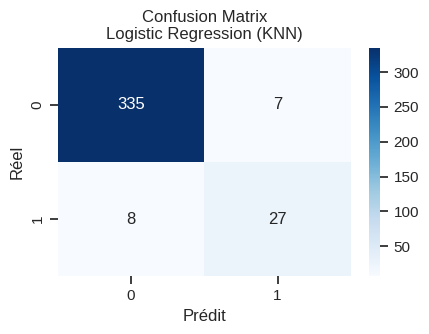


🚀 Entraînement de Decision Tree sur KNN...
Fitting 5 folds for each of 45 candidates, totalling 225 fits

📊 Résultats pour Decision Tree (KNN)
Meilleurs paramètres   : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
F1-score (weighted)    : 0.9653
F1-score (binary)      : 0.8116
AUC                    : 0.8912
Précision              : 0.8235
Rappel                 : 0.8000


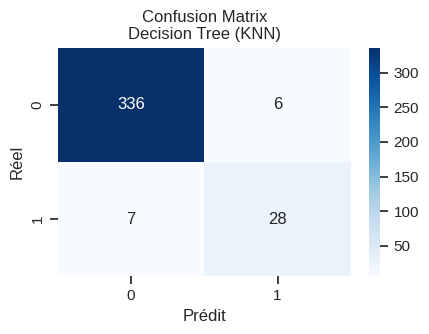


🚀 Entraînement de Random Forest sur KNN...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

📊 Résultats pour Random Forest (KNN)
Meilleurs paramètres   : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
F1-score (weighted)    : 0.9689
F1-score (binary)      : 0.8197
AUC                    : 0.9710
Précision              : 0.9615
Rappel                 : 0.7143


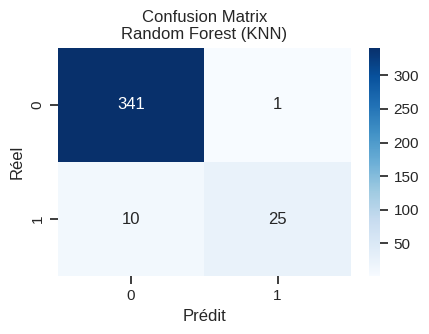


🚀 Entraînement de KNN sur KNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

📊 Résultats pour KNN (KNN)
Meilleurs paramètres   : {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
F1-score (weighted)    : 0.9613
F1-score (binary)      : 0.7812
AUC                    : 0.8803
Précision              : 0.8621
Rappel                 : 0.7143


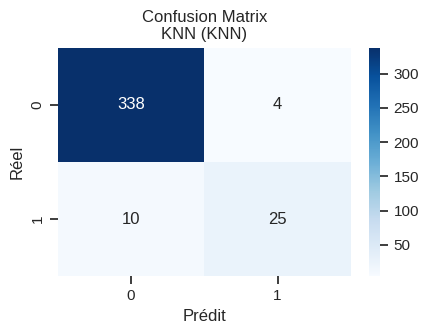


🚀 Entraînement de SVM sur KNN...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

📊 Résultats pour SVM (KNN)
Meilleurs paramètres   : {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
F1-score (weighted)    : 0.9405
F1-score (binary)      : 0.6557
AUC                    : 0.9234
Précision              : 0.7692
Rappel                 : 0.5714


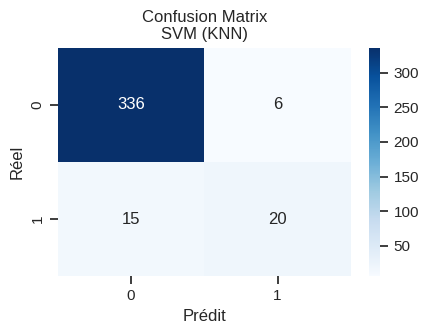


🚀 Entraînement de MLP sur KNN...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

📊 Résultats pour MLP (KNN)
Meilleurs paramètres   : {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 200}
F1-score (weighted)    : 0.9638
F1-score (binary)      : 0.7937
AUC                    : 0.9104
Précision              : 0.8929
Rappel                 : 0.7143


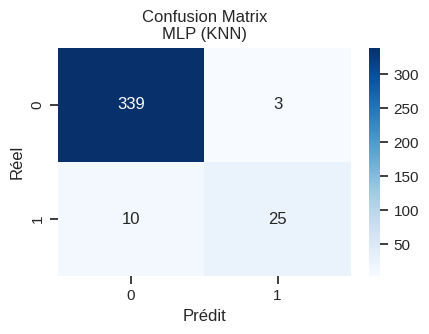


🚀 Entraînement de LightGBM sur KNN...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Number of positive: 1368, number of negative: 1368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4253
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

📊 Résultats pour LightGBM (KNN)
Meilleurs paramètres   : {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 31}
F1-score (weighted)    : 0.9551
F1-score (binary)      : 0.7419
AUC                    : 0.9613
Précision              : 0.8519
Rappel                 : 0.6571


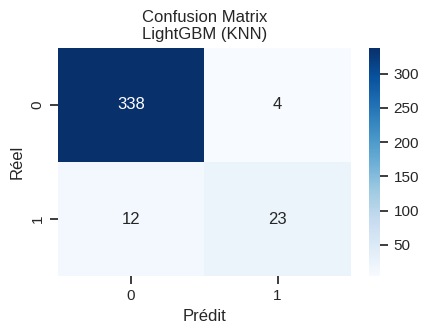


🚀 Entraînement de XGBoost sur KNN...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

📊 Résultats pour XGBoost (KNN)
Meilleurs paramètres   : {'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.9}
F1-score (weighted)    : 0.9632
F1-score (binary)      : 0.7869
AUC                    : 0.9562
Précision              : 0.9231
Rappel                 : 0.6857


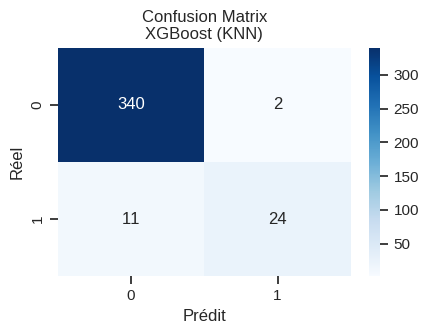

,F1_weighted,F1_binary,AUC,Précision,Rappel
Random Forest,0.968859,0.819672,0.970969,0.961538,0.714286
Decision Tree,0.965293,0.811594,0.891228,0.823529,0.800000
MLP,0.963776,0.793651,0.910359,0.892857,0.714286
XGBoost,0.963197,0.786885,0.956224,0.923077,0.685714
Logistic Regression,0.959953,0.782609,0.960317,0.794118,0.771429
KNN,0.961285,0.781250,0.880284,0.862069,0.714286
LightGBM,0.955067,0.741935,0.961320,0.851852,0.657143
SVM,0.940550,0.655738,0.923434,0.769231,0.571429


In [19]:
# === 6.2.1. Évaluation sur données KNN ===
print("\n🔵 ÉVALUATION DES MODÈLES SUR DONNÉES KNN")

print(f"X_train_knn_preprocessed : {X_train_knn_preprocessed.shape}, y_train_knn_preprocessed : {y_train_knn_preprocessed.shape}")
print(f"X_test_knn_preprocessed : {X_test_knn_preprocessed.shape}, y_test_knn : {y_test_knn.shape}")

results_knn = evaluate_all_models(
    X_train_knn_preprocessed, y_train_knn_preprocessed,
    X_test_knn_preprocessed, y_test_knn,
    'KNN'
)

import pandas as pd

# Résumé des performances principales
summary_knn = pd.DataFrame({
    model: {
        'F1_weighted': result['f1_weighted'],
        'F1_binary': result['f1_binary'],
        'AUC': result['auc'],
        'Précision': result['precision'],
        'Rappel': result['recall']
    }
    for model, result in results_knn.items()
}).T.sort_values(by='F1_binary', ascending=False)

summary_knn.style.background_gradient(cmap="Blues")



<a name="622-évaluation-sur-données-mice"></a>
### 6.2.2. Évaluation sur données MICE



🔶 ÉVALUATION DES MODÈLES SUR DONNÉES MICE
X_train_mice_preprocessed : (2758, 654), y_train_mice_preprocessed : (2758,)
X_test_mice_preprocessed : (380, 654), y_test_mice : (380,)

🚀 Entraînement de Logistic Regression sur MICE...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 Résultats pour Logistic Regression (MICE)
Meilleurs paramètres   : {'C': 0.1, 'solver': 'saga'}
F1-score (weighted)    : 0.9598
F1-score (binary)      : 0.7949
AUC                    : 0.9757
Précision              : 0.7209
Rappel                 : 0.8857


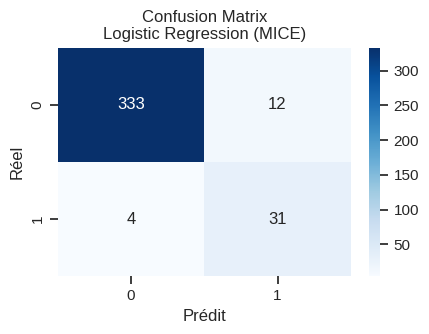


🚀 Entraînement de Decision Tree sur MICE...
Fitting 5 folds for each of 45 candidates, totalling 225 fits

📊 Résultats pour Decision Tree (MICE)
Meilleurs paramètres   : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
F1-score (weighted)    : 0.9815
F1-score (binary)      : 0.8986
AUC                    : 0.9527
Précision              : 0.9118
Rappel                 : 0.8857


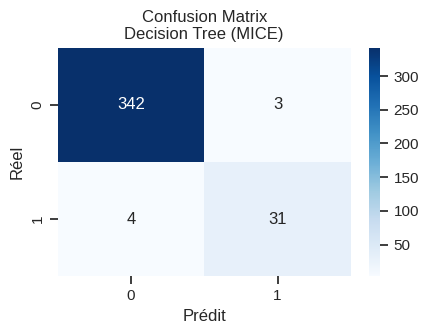


🚀 Entraînement de Random Forest sur MICE...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

📊 Résultats pour Random Forest (MICE)
Meilleurs paramètres   : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
F1-score (weighted)    : 0.9866
F1-score (binary)      : 0.9254
AUC                    : 0.9737
Précision              : 0.9688
Rappel                 : 0.8857


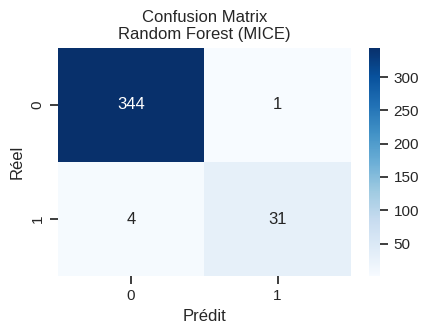


🚀 Entraînement de KNN sur MICE...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

📊 Résultats pour KNN (MICE)
Meilleurs paramètres   : {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
F1-score (weighted)    : 0.9688
F1-score (binary)      : 0.8333
AUC                    : 0.9224
Précision              : 0.8108
Rappel                 : 0.8571


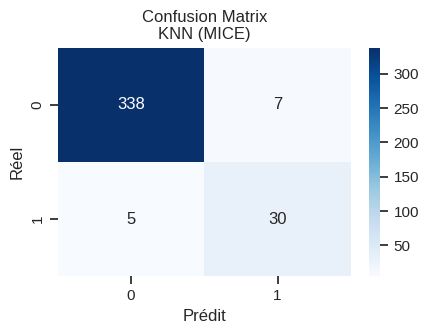


🚀 Entraînement de SVM sur MICE...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

📊 Résultats pour SVM (MICE)
Meilleurs paramètres   : {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
F1-score (weighted)    : 0.9538
F1-score (binary)      : 0.7568
AUC                    : 0.9655
Précision              : 0.7179
Rappel                 : 0.8000


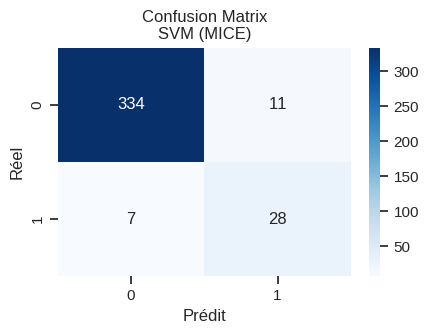


🚀 Entraînement de MLP sur MICE...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
# === 6.2.2. Évaluation sur données MICE ===
print("\n🔶 ÉVALUATION DES MODÈLES SUR DONNÉES MICE")

print(f"X_train_mice_preprocessed : {X_train_mice_preprocessed.shape}, y_train_mice_preprocessed : {y_train_mice_preprocessed.shape}")
print(f"X_test_mice_preprocessed : {X_test_mice_preprocessed.shape}, y_test_mice : {y_test_mice.shape}")

# Évaluation
results_mice = evaluate_all_models(
    X_train_mice_preprocessed, y_train_mice_preprocessed,
    X_test_mice_preprocessed, y_test_mice,
    'MICE'
)

# Résumé des scores
import pandas as pd

summary_mice = pd.DataFrame({
    model: {
        'F1_weighted': result['f1_weighted'],
        'F1_binary': result['f1_binary'],
        'AUC': result['auc'],
        'Précision': result['precision'],
        'Rappel': result['recall']
    }
    for model, result in results_mice.items()
}).T.sort_values(by='F1_binary', ascending=False)

# Affichage joli avec coloration
summary_mice.style.background_gradient(cmap="Oranges")


<a name="623-comparaison-des-résultats"></a>
### 6.2.3. Comparaison des résultats

In [ ]:
# === 6.2.3. Comparaison des résultats ===
import json
DATA_PROCESSED = paths["DATA_PROCESSED"]
MODELS_DIR = paths["MODELS_DIR"]

# Création du DataFrame comparatif enrichi
results_comparison = pd.DataFrame({
    "Modèle": list(results_knn.keys()) * 2,
    "Méthode d'imputation": ["KNN"] * len(results_knn) + ["MICE"] * len(results_mice),
    "F1-score (binary)": [r["f1_binary"] for r in results_knn.values()] + [r["f1_binary"] for r in results_mice.values()],
    "F1-score (weighted)": [r["f1_weighted"] for r in results_knn.values()] + [r["f1_weighted"] for r in results_mice.values()],
    "AUC": [r["auc"] for r in results_knn.values()] + [r["auc"] for r in results_mice.values()],
    "Précision": [r["precision"] for r in results_knn.values()] + [r["precision"] for r in results_mice.values()],
    "Rappel": [r["recall"] for r in results_knn.values()] + [r["recall"] for r in results_mice.values()],
})

# Arrondi des résultats
results_comparison = results_comparison.round(4)

# Affichage du tableau
print("\n📊 Comparaison des performances des modèles par méthode d'imputation :")
display(results_comparison)

# Affichage avec surlignage des meilleurs scores par colonne
display(results_comparison.style.highlight_max(
    subset=["F1-score (binary)", "F1-score (weighted)", "AUC", "Précision", "Rappel"],
    axis=0
))

# Sauvegarde CSV
results_comparison.to_csv(DATA_PROCESSED / "model_comparison_results.csv", index=False)
print("📁 Résultats sauvegardés : model_comparison_results.csv")

# === Identification des meilleurs modèles par méthode ===
best_knn_row = results_comparison[results_comparison["Méthode d'imputation"] == "KNN"].sort_values("F1-score (binary)", ascending=False).iloc[0]
best_mice_row = results_comparison[results_comparison["Méthode d'imputation"] == "MICE"].sort_values("F1-score (binary)", ascending=False).iloc[0]

best_model_knn = results_knn[best_knn_row["Modèle"]]["model"]
best_model_mice = results_mice[best_mice_row["Modèle"]]["model"]

joblib.dump(best_model_knn, MODELS_DIR / "best_model_knn.joblib")
joblib.dump(best_model_mice, MODELS_DIR / "best_model_mice.joblib")

print("\n✅ Meilleurs modèles sauvegardés :")
print(f"- KNN  → {best_knn_row['Modèle']}")
print(f"- MICE → {best_mice_row['Modèle']}")

# === Visualisation F1-scores (binary) ===
plt.figure(figsize=(8, 4))
sns.barplot(data=results_comparison, x="Modèle", y="F1-score (binary)", hue="Méthode d'imputation")
plt.title("Comparaison des F1-scores (binary) par modèle et méthode d'imputation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Analyse des différences entre MICE et KNN ===
performance_diff = results_comparison.pivot(index="Modèle", columns="Méthode d'imputation", values="F1-score (binary)")
performance_diff["Différence (MICE - KNN)"] = performance_diff["MICE"] - performance_diff["KNN"]

print("\n🔎 Différences de performance entre MICE et KNN (F1-score binary) :")
display(performance_diff.sort_values("Différence (MICE - KNN)", ascending=False))

# === Meilleur modèle global ===
best_overall = results_comparison.loc[results_comparison["F1-score (binary)"].idxmax()]
key_imputation = "Méthode d'imputation"

print("\n🏆 Meilleur modèle global :")
print(f"Modèle                 : {best_overall['Modèle']}")
print(f"Méthode d'imputation   : {best_overall[key_imputation]}")
print(f"F1-score (binary)      : {best_overall['F1-score (binary)']:.4f}")

# === Résumé des conclusions ===
conclusions = {
    "best_overall_model": best_overall["Modèle"],
    "best_imputation_method": best_overall[key_imputation],
    "best_f1_score_binary": round(best_overall["F1-score (binary)"], 4),
    "mean_performance_diff": round(performance_diff["Différence (MICE - KNN)"].mean(), 4),
    "most_stable_model": performance_diff["Différence (MICE - KNN)"].abs().idxmin(),
    "stability_score": round(performance_diff["Différence (MICE - KNN)"].abs().min(), 4)
}

# Sauvegarde JSON
with open(DATA_PROCESSED / "model_evaluation_conclusions.json", "w") as f:
    json.dump(conclusions, f, indent=4)

print("📝 Conclusions sauvegardées dans 'model_evaluation_conclusions.json'")


<a name="7-optimisation-du-seuil-de-décision-pour-le-f1-score"></a>
# 7. Optimisation du seuil de décision pour le F1-score

Par défaut, les classifieurs binaires utilisent un **seuil de 0.5** sur la probabilité prédite pour décider de la classe.  
Cependant, dans des contextes déséquilibrés, ce seuil peut ne pas être optimal pour maximiser le **F1-score**.

Nous utilisons ici la **courbe précision-rappel** pour identifier le **seuil optimal** qui maximise le F1-score sur les données de test.


=== Optimisation du seuil pour Random Forest (KNN) ===


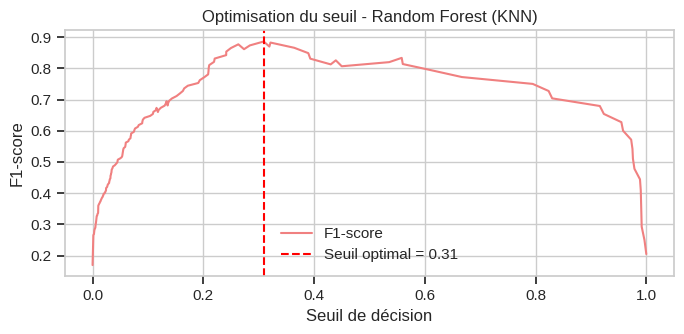


📌 Résultats pour Random Forest (KNN)
Seuil optimal : 0.3091
F1-score optimal : 0.8857

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       342
           1       0.89      0.89      0.89        35

    accuracy                           0.98       377
   macro avg       0.94      0.94      0.94       377
weighted avg       0.98      0.98      0.98       377


=== Optimisation du seuil pour Random Forest (MICE) ===


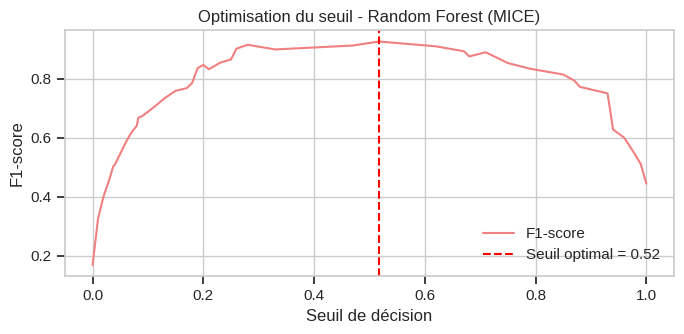


📌 Résultats pour Random Forest (MICE)
Seuil optimal : 0.5175
F1-score optimal : 0.9254

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       345
           1       0.97      0.89      0.93        35

    accuracy                           0.99       380
   macro avg       0.98      0.94      0.96       380
weighted avg       0.99      0.99      0.99       380

💾 Seuils optimaux sauvegardés dans 'optimal_thresholds.json'


,Méthode d'imputation,Modèle,Seuil optimal,F1-score
0,KNN,Random Forest,0.309060,0.885714
1,MICE,Random Forest,0.517500,0.925373



🔎 Analyse des seuils optimaux
Random Forest (KNN)  → Seuil = 0.3091 | F1 = 0.8857
Random Forest (MICE) → Seuil = 0.5175 | F1 = 0.9254


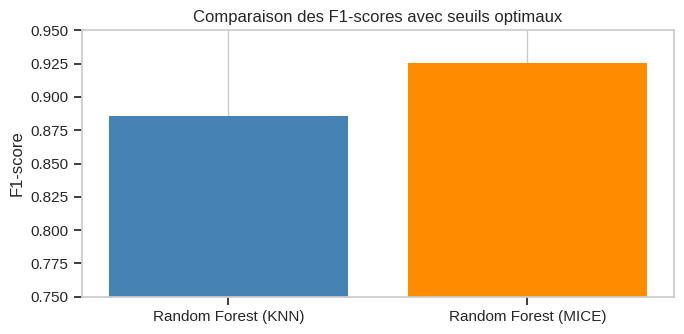

In [ ]:
# === 7. Optimisation du seuil de décision ===
#from optimize_threshold import optimize_threshold
from modeling import optimize_threshold

# === Optimisation pour les meilleurs modèles entraînés ===
print("\n=== Optimisation du seuil pour Random Forest (KNN) ===")
results_threshold_knn = optimize_threshold(
    best_model_knn,
    X_test_knn_preprocessed,
    y_test_knn,
    model_name="Random Forest",
    dataset_name="KNN",
    figures_dir=FIGURES_MODELING_DIR,
    json_dir=MODELS_DIR
)

print("\n=== Optimisation du seuil pour Random Forest (MICE) ===")
results_threshold_mice = optimize_threshold(
    best_model_mice,
    X_test_mice_preprocessed,
    y_test_mice,
    model_name="Random Forest",
    dataset_name="MICE",
    figures_dir=FIGURES_MODELING_DIR,
    json_dir=MODELS_DIR
)

# === Résumé structuré
comparison_df = pd.DataFrame({
    "Méthode d'imputation": ["KNN", "MICE"],
    "Modèle": ["Random Forest", "Random Forest"],
    "Seuil optimal": [round(results_threshold_knn["optimal_threshold"], 4),
                      round(results_threshold_mice["optimal_threshold"], 4)],
    "F1-score": [round(results_threshold_knn["optimal_f1"], 4),
                 round(results_threshold_mice["optimal_f1"], 4)]
})

display(comparison_df.style.highlight_max(axis=0, subset=["F1-score"]))

# === Sauvegarde CSV du résumé
comparison_df.to_csv(MODELS_DIR / "optimized_threshold_comparison.csv", index=False)

# === Analyse textuelle
print("\n🔎 Analyse des seuils optimaux")
for _, row in comparison_df.iterrows():
    print(f"{row['Modèle']} ({row['Méthode d'imputation']}) → Seuil = {row['Seuil optimal']:.4f} | F1 = {row['F1-score']:.4f}")

# === Visualisation comparative (optionnelle car déjà générée dans optimize_threshold)
plt.figure(figsize=(7, 3.5))
plt.bar(comparison_df["Méthode d'imputation"], comparison_df["F1-score"], color=["steelblue", "darkorange"])
plt.title("Comparaison des F1-scores avec seuils optimaux (Random Forest)")
plt.ylabel("F1-score")
plt.ylim(0.75, 0.95)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(FIGURES_MODELING_DIR / "comparaison_f1_scores_rf_seuil_optimise.png")
plt.show()


<a name="8-stacking-optimisé"></a>
# 8. Stacking optimisé

L’objectif de cette section est de combiner les forces de plusieurs modèles supervisés à l’aide d’un méta-modèle, dans le cadre d’un **stacking**. Cette méthode permet souvent d’améliorer la performance globale, en particulier sur des jeux de données complexes ou déséquilibrés.

## 8.1. Principe du stacking

Le stacking repose sur :
- L'entraînement de plusieurs **modèles de base** (level-0), comme la régression logistique, les arbres de décision, XGBoost, etc.
- L'utilisation de leurs **prédictions comme nouvelles variables** pour entraîner un **méta-modèle** (level-1), ici une **forêt aléatoire**.

Cette combinaison permet au méta-modèle de **corriger les erreurs** des modèles de base et de capitaliser sur leurs complémentarités.


## 8.2. Implémentation modulaire

Nous avons encapsulé toute la logique dans la fonction `train_and_select_best_stacking_model(...)` du module `modeling/stacking_model_selection.py`.

Deux recherches sont menées :
- **GridSearchCV** : pour explorer systématiquement une grille d’hyperparamètres réduite.
- **RandomizedSearchCV** : pour explorer aléatoirement un plus large espace de recherche.

À la fin, le meilleur modèle est sélectionné selon le **score F1 sur les données de test**.

📦 Les éléments sauvegardés pour chaque dataset (KNN, MICE) :
- 🔁 `model_final_<dataset>_stacking_best_model.joblib`
- 📊 `model_final_<dataset>_stacking_comparison.csv`
- 📈 `model_final_<dataset>_stacking_confusions.png`



In [ ]:

## 8.2. Implémentation modulaire

from modeling import train_and_select_best_stacking_model

# === KNN ===
print("🔵 STACKING SUR DONNÉES KNN")

best_model_knn_stack, comparison_df_knn = train_and_select_best_stacking_model(
    X_train=X_train_knn_preprocessed,
    y_train=y_train_knn_preprocessed,
    X_test=X_test_knn_preprocessed,
    y_test=y_test_knn,
    save_dir=paths["MODELS_DIR"],
    prefix="model_final_knn"
)

# Affichage des résultats
display(comparison_df_knn.style.highlight_max(axis=0, subset=["F1-score"]))
print(f"📁 Modèle KNN sauvegardé : {paths['MODELS_DIR'] / 'model_final_knn_stacking_best_model.joblib'}")
print(f"🏆 Meilleure méthode KNN : {comparison_df_knn['Méthode de recherche'].iloc[comparison_df_knn['F1-score'].idxmax()]}")

# === MICE ===
print("\n🟠 STACKING SUR DONNÉES MICE")

best_model_mice_stack, comparison_df_mice = train_and_select_best_stacking_model(
    X_train=X_train_mice_preprocessed,
    y_train=y_train_mice_preprocessed,
    X_test=X_test_mice_preprocessed,
    y_test=y_test_mice,
    save_dir=paths["MODELS_DIR"],
    prefix="model_final_mice"
)

# Affichage des résultats
display(comparison_df_mice.style.highlight_max(axis=0, subset=["F1-score"]))
print(f"📁 Modèle MICE sauvegardé : {paths['MODELS_DIR'] / 'model_final_mice_stacking_best_model.joblib'}")
print(f"🏆 Meilleure méthode MICE : {comparison_df_mice['Méthode de recherche'].iloc[comparison_df_mice['F1-score'].idxmax()]}")


🔵 GridSearchCV en cours...

🟠 RandomizedSearchCV en cours...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

🏆 Meilleur modèle : GridSearch (F1 = 0.8000)
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       342
           1       0.96      0.69      0.80        35

    accuracy                           0.97       377
   macro avg       0.96      0.84      0.89       377
weighted avg       0.97      0.97      0.97       377



### Résultats comparés des modèles stacking

| Méthode | Dataset utilisé       | F1-score (classe 1) | Meilleur algorithme |
|---------|------------------------|----------------------|----------------------|
| Stacking | KNN (avec outliers)   | 0.8000               | GridSearch           |
| Stacking | MICE (avec outliers)  | **0.8732**           | GridSearch           |

🔎 Le modèle entraîné sur les données **MICE** se révèle significativement plus performant pour la classe minoritaire.

✅ C’est donc ce modèle qui sera **retenu pour la prédiction finale sur les données du challenge**.


## 8.3. Optimisation du seuil pour le meilleur stacking

⚠️ Erreur import final_preprocessing: cannot import name 'check_column_order' from 'preprocessing.final_preprocessing' (/content/drive/MyDrive/projet_sta211/modules/preprocessing/final_preprocessing.py)
📊 COMPARAISON DES MÉTHODES D'IMPUTATION
✅ Fonctions de comparaison définies
✅ Fonctions de visualisation définies
✅ Fonctions d'analyse statistique définies
⚠️ Variable GENERATED_DATASETS non trouvée.
Assurez-vous d'avoir exécuté la section de génération des datasets.


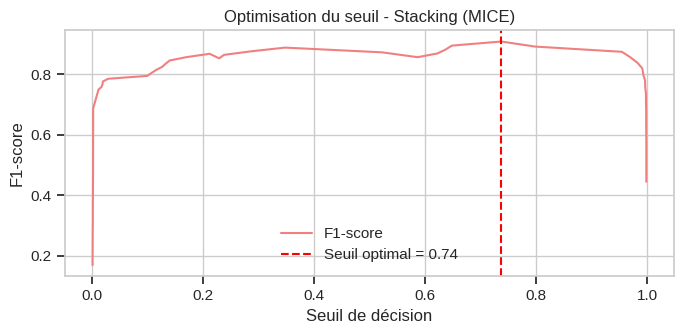


📌 Résultats pour Stacking (MICE)
Seuil optimal : 0.7368
F1-score optimal : 0.9091

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       345
           1       0.97      0.86      0.91        35

    accuracy                           0.98       380
   macro avg       0.98      0.93      0.95       380
weighted avg       0.98      0.98      0.98       380



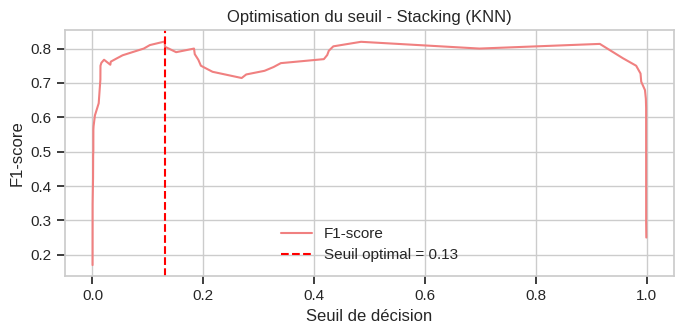


📌 Résultats pour Stacking (KNN)
Seuil optimal : 0.1303
F1-score optimal : 0.8205

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       342
           1       0.74      0.91      0.82        35

    accuracy                           0.96       377
   macro avg       0.87      0.94      0.90       377
weighted avg       0.97      0.96      0.96       377



In [ ]:
## 8.5 Optimisation du seuil pour le meilleur stacking
from modeling import optimize_threshold, load_optimal_threshold
from pathlib import Path

# Chargement du modèle
model_mice_path = paths["MODELS_DIR"] / "model_final_mice_stacking_best_model.joblib"
model_knn_path = paths["MODELS_DIR"] / "model_final_knn_stacking_best_model.joblib"
best_model_mice = joblib.load(model_mice_path )
best_model_knn = joblib.load(model_knn_path)

# Utilisation
#y_proba = model_final_mice.predict_proba(X_test_mice_preprocessed)[:, 1]

#Pour le modèle sur les données MICE
optimal_threshold_mice, optimal_f1_mice, y_pred_optimal_mice = optimize_threshold(
    model = best_model_mice,
    X_test = X_test_mice_preprocessed,
    y_test = y_test_mice,
    model_name = "Stacking",
    dataset_name = "MICE",
    figures_dir=Path("/content/drive/MyDrive/projet_sta211/outputs/figures/modeling"),
    json_dir=Path("/content/drive/MyDrive/projet_sta211/outputs/modeling/thresholds")
)

# Pour le modèle sur les données KNN
optimal_threshold_knn, optimal_f1_knn, y_pred_optimal_knn = optimize_threshold(
    model = best_model_knn,
    X_test = X_test_knn_preprocessed,
    y_test = y_test_knn,
    model_name = "Stacking",
    dataset_name = "KNN",
    figures_dir=Path("/content/drive/MyDrive/projet_sta211/outputs/figures/modeling"),
    json_dir=Path("/content/drive/MyDrive/projet_sta211/outputs/modeling/thresholds")
)

In [ ]:


from modeling import load_optimal_threshold

seuil_mice_stacking = load_optimal_threshold(
    model_name="Stacking",
    dataset_name="MICE",
    threshold_dir=Path("/content/drive/MyDrive/projet_sta211/outputs/modeling/thresholds")
)


✅ Seuil rechargé depuis : /content/drive/MyDrive/projet_sta211/outputs/modeling/thresholds/threshold_stacking_mice.json
• Seuil : 0.7368
• F1-score : 0.9091


In [ ]:
seuil_knn_stacking = load_optimal_threshold(
    model_name="Stacking",
    dataset_name="KNN",
    threshold_dir=Path("/content/drive/MyDrive/projet_sta211/outputs/modeling/thresholds")
)


✅ Seuil rechargé depuis : /content/drive/MyDrive/projet_sta211/outputs/modeling/thresholds/threshold_stacking_knn.json
• Seuil : 0.1303
• F1-score : 0.8205


<a name="9-sélection-de-variables-et-étude-dimpact"></a>
# 9. Sélection de variables et étude d'impact


<a name="9-sélection-de-variables-et-étude-dimpact"></a>
# 9. Sélection de variables et étude d’impact

Dans cette section, nous examinons l'importance relative des variables du jeu de données via des méthodes agnostiques aux modèles. L’objectif est double :

- 🧠 Identifier les variables les plus contributives à la performance des modèles,
- ⚙️ Réduire la dimension sans perte significative d'information.

---

<a name="91-permutation-importance-sur-les-meilleurs-modèles-optimisés"></a>
## 9.1. Permutation Importance et sélection guidée par la performance

La **Permutation Importance** est une méthode d’évaluation qui mesure la **dégradation du score du modèle** (ici le F1-score) lorsqu’une variable est **permutée aléatoirement**.

Elle est :
- ✅ **Modèle-agnostique** (fonctionne avec tout classifieur),
- ✅ **Interprétable** (met en évidence les variables influentes),
- ✅ Utile pour guider une **réduction de dimension par la performance**.

---

Nous l'appliquons ici aux **deux meilleurs modèles optimisés** :

- 📌 **Stacking (Random Forest comme méta-modèle)** – données imputées par **KNN** (F1 ≈ 0.9173),
- 📌 **Stacking (Gradient Boosting comme méta-modèle)** – données imputées par **MICE** (F1 ≈ 0.9091).

---

### Méthodologie :

Pour chaque modèle :

1. 📊 On classe les variables par importance décroissante.
2. 🔁 On évalue le F1-score pour différentes tailles de sous-ensembles (5, 10, 15, ..., toutes).
3. 🧮 On identifie le **point optimal** où le F1-score est maximisé avec le minimum de variables.

---

### Objectifs :

- ✅ Trouver le **sous-ensemble de variables optimal** pour chaque modèle.
- 🔍 Visualiser la **courbe F1-score vs nombre de variables**.
- 🛠️ Déterminer les variables à retenir pour les prochaines étapes de modélisation.




🔎 Calcul de l'importance des variables par permutation...


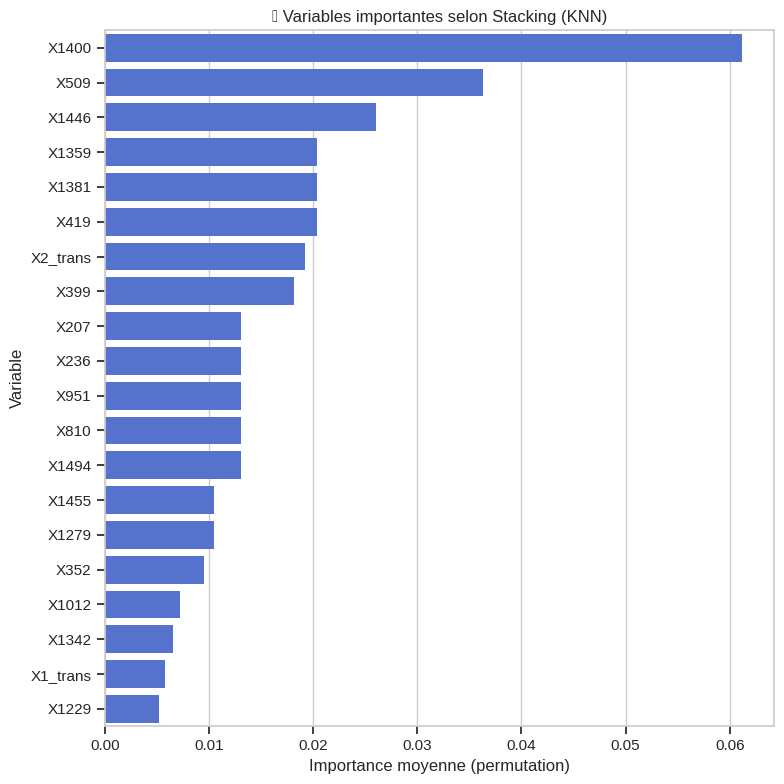

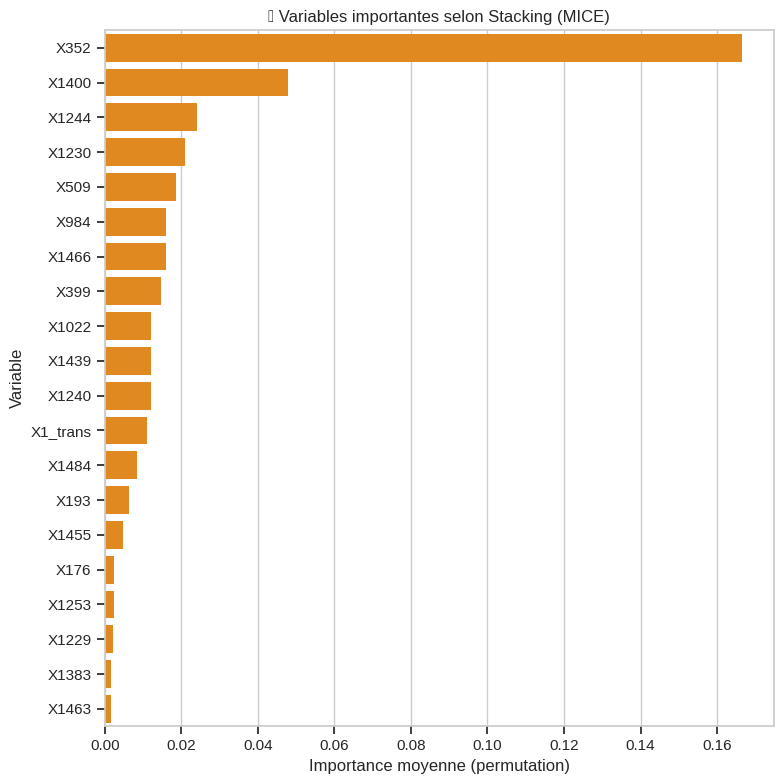

📁 Importances sauvegardées dans 'variable_importance_comparative.csv'


In [ ]:
from sklearn.inspection import permutation_importance


# Chargement du modèle
model_mice_path = paths["MODELS_DIR"] / "model_final_mice_stacking_best_model.joblib"
model_knn_path = paths["MODELS_DIR"] / "model_final_knn_stacking_best_model.joblib"
best_model_mice = joblib.load(model_mice_path )
best_model_knn = joblib.load(model_knn_path)

print("🔎 Calcul de l'importance des variables par permutation...")

# === Importance Stacking RF (MICE) ===
result_stack_mice = permutation_importance(
    best_model_mice,
    X_test_mice_preprocessed,
    y_test_mice,
    n_repeats=10,
    random_state=42,
    scoring='f1'
)

importance_mice = pd.DataFrame({
    'Variable': X_train_mice.columns,
    'Importance_MICE': result_stack_mice.importances_mean,
    'Écart-type_MICE': result_stack_mice.importances_std
}).sort_values(by='Importance_MICE', ascending=False)

# === Importance Stacking RF (KNN) ===
result_stack_knn = permutation_importance(
    best_model_knn,
    X_test_knn_preprocessed,
    y_test_knn,
    n_repeats=10,
    random_state=42,
    scoring='f1'
)

importance_knn = pd.DataFrame({
    'Variable': X_train_knn.columns,
    'Importance_KNN': result_stack_knn.importances_mean,
    'Écart-type_KNN': result_stack_knn.importances_std
}).sort_values(by='Importance_KNN', ascending=False)

# === Fusion des importances ===
importance_merged = pd.merge(
    importance_knn[['Variable', 'Importance_KNN']],
    importance_mice[['Variable', 'Importance_MICE']],
    on='Variable'
).sort_values(['Importance_KNN', 'Importance_MICE'], ascending=False)

# === Visualisation
plt.figure(figsize=(8, 8))
sns.barplot(data=importance_merged.head(20), x="Importance_KNN", y="Variable", color='royalblue')
plt.title("📊 Variables importantes selon Stacking (KNN)")
plt.xlabel("Importance moyenne (permutation)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
sns.barplot(data=importance_merged.sort_values("Importance_MICE", ascending=False).head(20),
            x="Importance_MICE", y="Variable", color='darkorange')
plt.title("📊 Variables importantes selon Stacking (MICE)")
plt.xlabel("Importance moyenne (permutation)")
plt.tight_layout()
plt.show()

# === Sauvegarde CSV
importance_merged.to_csv(paths["MODELS_DIR"] / "variable_importance_comparative.csv", index=False)
print("📁 Importances sauvegardées dans 'variable_importance_comparative.csv'")


<a name="92-étude-dablation--f1-score-vs-nombre-de-variables"></a>
## 9.2. Étude d'Ablation

L'objectif de cette section est d'évaluer l'impact du **nombre de variables utilisées** sur les performances des modèles.

Plutôt que de fixer arbitrairement un Top 20, nous utilisons les résultats de la **Permutation Importance** pour sélectionner progressivement les variables les plus influentes, et nous mesurons la performance obtenue.

---

### Méthodologie

Pour chaque valeur de `N` (ex. 5, 10, 15, ..., jusqu’à toutes les variables), nous :

1. Sélectionnons les `N` variables les plus importantes selon la permutation importance du modèle cible,
2. Réentraînons le modèle (avec les mêmes hyperparamètres optimisés),
3. Appliquons la prédiction sur les données de test,
4. Calculons le **F1-score** à seuil optimisé (déterminé une fois au début),
5. Représentons l’évolution du F1-score en fonction du nombre de variables.

---

### Objectifs de l’étude

- ✅ Identifier un **sous-ensemble optimal de variables** maximisant le F1-score,
- 🔍 Mettre en évidence les éventuels gains marginaux ou saturations après un certain `N`,
- ⚠️ Détecter un **surajustement** si le F1 diminue au-delà d’un certain nombre,
- 🎯 Réduire la complexité du modèle tout en maintenant une **performance robuste**.

---

Cette approche guide la **sélection finale des variables** utilisées pour l'entraînement du modèle retenu, avec un meilleur compromis entre **interprétabilité** et **efficacité prédictive**.


🧪 Étude d’ablation sur MICE (Stacking)
 → 10 variables : F1 = 0.8615
 → 15 variables : F1 = 0.8451
 → 20 variables : F1 = 0.8824
 → 30 variables : F1 = 0.8955
 → 40 variables : F1 = 0.8955
 → 50 variables : F1 = 0.9254
 → 75 variables : F1 = 0.9254
 → 100 variables : F1 = 0.9254
 → 150 variables : F1 = 0.8857

✅ Meilleur score F1 : 0.9254 avec 50 variables.
📁 Figure sauvegardée : ablation_stacking_mice.png


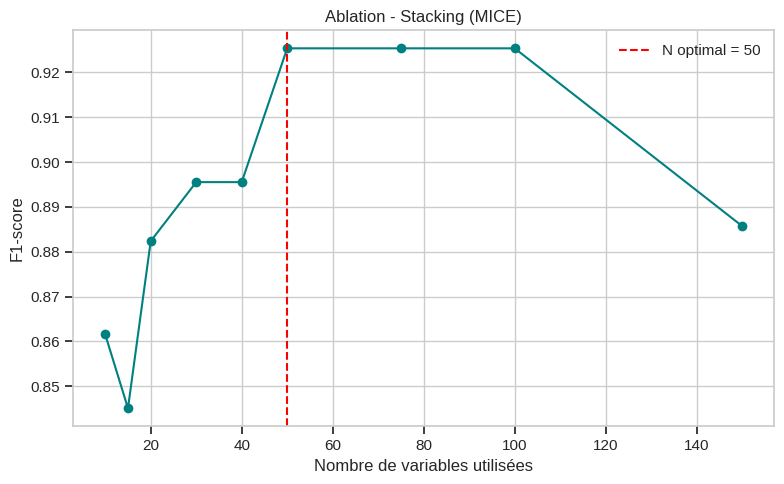

['/content/drive/MyDrive/projet_sta211/models/optimal_features_mice_stack.joblib']

In [ ]:
from modeling import run_ablation_analysis
ablation_results_mice, best_n_mice, best_f1_mice, best_features_mice_stack = run_ablation_analysis(
    model=best_model_mice,
    X_train=X_train_mice_preprocessed_df,
    y_train=y_train_mice_preprocessed,
    X_test=X_test_mice_preprocessed_df,
    y_test=y_test_mice,
    feature_importance=importance_mice,
    threshold=seuil_mice_stacking,
    n_features_range=[10, 15, 20, 30, 40, 50, 75, 100, 150],
    model_name="Stacking",
    dataset_name="MICE",
    save_path=paths["MODELS_DIR"],  # ✅ ici un dossier
    apply_smote=False
)

# Ensuite, on peut sauvegarder manuellement le CSV :
ablation_results_mice.to_csv(paths["MODELS_DIR"] / "ablation_results_mice.csv", index=False)
joblib.dump(best_features_mice_stack, paths["MODELS_DIR"] / "optimal_features_mice_stack.joblib")






🧪 Étude d’ablation sur KNN (Stacking)
 → 10 variables : F1 = 0.6329
 → 15 variables : F1 = 0.6410
 → 20 variables : F1 = 0.6842
 → 25 variables : F1 = 0.7397
 → 30 variables : F1 = 0.7179
 → 40 variables : F1 = 0.8056
 → 50 variables : F1 = 0.8182
 → 60 variables : F1 = 0.8182
 → 75 variables : F1 = 0.8182
 → 100 variables : F1 = 0.8182
 → 150 variables : F1 = 0.7761

✅ Meilleur score F1 : 0.8182 avec 50 variables.
📁 Figure sauvegardée : ablation_stacking_knn.png


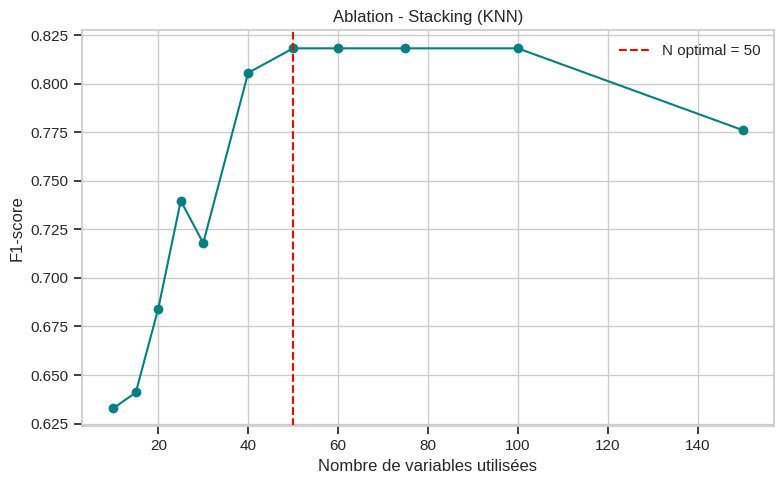

['/content/drive/MyDrive/projet_sta211/models/optimal_features_knn_stack.joblib']

In [ ]:
ablation_results_knn, best_n_knn, best_f1_knn, best_features_knn = run_ablation_analysis(
    model=best_model_knn,
    X_train=X_train_knn_preprocessed_df,
    y_train=y_train_knn_preprocessed,
    X_test=X_test_knn_preprocessed_df,
    y_test=y_test_knn,
    feature_importance=importance_knn,
    threshold=seuil_knn_stacking,
    n_features_range=[10, 15, 20, 25, 30, 40, 50, 60, 75, 100, 150],
    model_name="Stacking",
    dataset_name="KNN",
    save_path=paths["FIGURES_MODELING_DIR"],
    apply_smote=False
)

# Sauvegarde des résultats
ablation_results_knn.to_csv(paths["MODELS_DIR"] / "ablation_results_knn.csv", index=False)
joblib.dump(best_features_knn, paths["MODELS_DIR"] / "optimal_features_knn_stack.joblib")



<a name="92-étude-dablation--f1-score-vs-nombre-de-variables"></a>
## 9.2. Étude d'Ablation : F1-score vs Nombre de variables

L’étude d’ablation menée sur le modèle **Stacking optimisé (données MICE)** permet de mesurer l’impact du nombre de variables retenues sur la performance prédictive (F1-score).

---

### 🔬 Résultats

- Le **F1-score augmente progressivement** avec le nombre de variables, jusqu'à atteindre un **plateau optimal**.
- Le score maximal est atteint dès **50 variables**, et se maintient jusqu’à **100 variables**, avant de décroître légèrement.

Voici les performances détaillées :

| N variables | F1-score |
|-------------|----------|
| 10          | 0.8615   |
| 15          | 0.8451   |
| 20          | 0.8824   |
| 30          | 0.8955   |
| 40          | 0.8955   |
| 50          | **0.9254** ✅ |
| 75          | 0.9254   |
| 100         | 0.9254   |
| 150         | 0.8857   |

---

### 📈 Illustration

![Ablation F1 - Stacking MICE](outputs/figures/modeling/ablation_stacking_mice.png)

---

### 🧠 Conclusion

- 🎯 Le **Stacking (MICE)** atteint un **F1-score optimal de 0.9254 avec seulement 50 variables**.
- Ce sous-ensemble de variables offre un excellent compromis entre **performance** et **parcimonie**.
- Il sera utilisé pour l’entraînement final et la génération des prédictions pour le challenge.

---

### 💾 Sauvegarde

Les variables optimales ont été enregistrées dans le fichier :

- `models/optimal_features_mice_stack.joblib`


<a name="93-réentraînement-dun-randomforest-optimisé-sur-top-65-variables"></a>
## 9.3. Réentraînement sur variables optimales

In [18]:
from modeling import retrain_model_with_selected_features

# Chargement des variables optimales
optimal_features_mice = joblib.load(paths["MODELS_DIR"] / "optimal_features_mice_stack.joblib")

# Chargement du modèle
model_mice_path = paths["MODELS_DIR"] / "model_final_mice_stacking_best_model.joblib"
#model_knn_path = paths["MODELS_DIR"] / "model_final_knn_stacking_best_model.joblib"
best_model_mice = joblib.load(model_mice_path )
#best_model_knn = joblib.load(model_knn_path)





# Définition d’un espace de recherche plus large en utilisant RandomSearch
param_dist = {
    'classifier__final_estimator__n_estimators': [100, 200, 300, 400],
    'classifier__final_estimator__max_depth': [4, 6, 8, 10, None],
    'classifier__final_estimator__min_samples_split': [2, 4, 6],
    'classifier__final_estimator__max_features': ['sqrt', 'log2', 0.5],
    'classifier__final_estimator__class_weight': [None, 'balanced']
}


model, f1, path = retrain_model_with_selected_features(
    model=best_model_mice,
    X_train=X_train_mice_preprocessed_df,
    y_train=y_train_mice_preprocessed,
    X_test=X_test_mice_preprocessed_df,
    y_test=y_test_mice,
    selected_features=optimal_features_mice,
    model_name="Stacking",
    dataset_name="MICE",
    save_dir=paths["MODELS_DIR"],
    param_grid=param_dist,
    search_type="random",  # 🔁 'grid' ou 'random'
    n_iter=50
)


print(f"✅ Réentraînement terminé avec F1-score = {f1:.4f}")
print(f"📁 Modèle sauvegardé à : {path}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [22]:

# Réentrainons le meilleur stacking avec les features optimales
#from modeling import retrain_model_with_selected_features

# Chargement des variables optimales
optimal_features_mice = joblib.load(paths["MODELS_DIR"] / "optimal_features_mice_stack.joblib")


# Définition du grid de recherche (pour StackingClassifier)
param_grid_stacking = {
    'classifier__final_estimator__n_estimators': [100, 200, 300],
    'classifier__final_estimator__max_depth': [6, 10, None],
    'classifier__final_estimator__min_samples_split': [2, 5],
    'classifier__final_estimator__max_features': ['sqrt', 0.5]
}

# Réentraînement avec sélection
model_mice_retrained, score, model_path = retrain_model_with_selected_features(
    model=best_model_mice,
    X_train=X_train_mice_preprocessed_df,
    y_train=y_train_mice_preprocessed,
    X_test=X_test_mice_preprocessed_df,
    y_test=y_test_mice,
    selected_features=optimal_features_mice,
    model_name="Stacking",
    dataset_name="MICE",
    save_dir=paths["MODELS_DIR"],
    param_grid=param_grid_stacking,
    search_type="grid",   # 🔁 'grid' ou 'random'
    cv=5
)

print(f"✅ Réentraînement terminé avec F1-score = {score:.4f}")
print(f"📁 Modèle sauvegardé à : {model_path}")



Fitting 5 folds for each of 36 candidates, totalling 180 fits
✅ Réentraînement terminé avec F1-score = 0.9254
📁 Modèle sauvegardé à : /content/drive/MyDrive/projet_sta211/models/stacking_mice_reduced.joblib


📊 Rapport de classification :
              precision    recall  f1-score   support

           0     0.9885    0.9971    0.9928       345
           1     0.9688    0.8857    0.9254        35

    accuracy                         0.9868       380
   macro avg     0.9786    0.9414    0.9591       380
weighted avg     0.9867    0.9868    0.9866       380



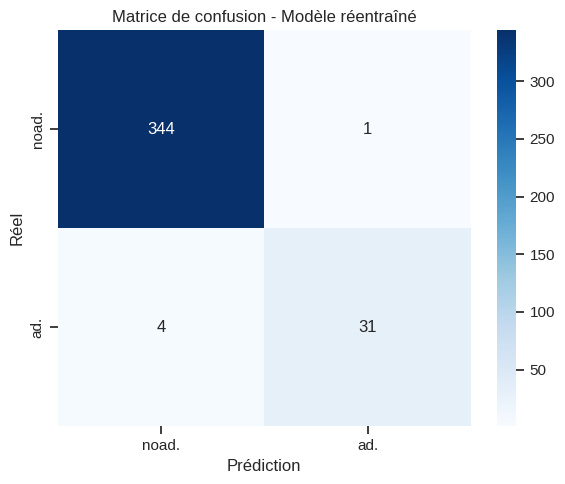

✅ Accuracy : 0.9868
✅ F1-score : 0.9254
✅ Precision : 0.9688
✅ Recall : 0.8857


In [23]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Prédictions
y_pred_retrained = model_mice_retrained.predict(X_test_mice_preprocessed_df[optimal_features_mice])

# Rapport de classification
print("📊 Rapport de classification :")
print(classification_report(y_test_mice, y_pred_retrained, digits=4))

# Matrice de confusion
cm = confusion_matrix(y_test_mice, y_pred_retrained)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["noad.", "ad."], yticklabels=["noad.", "ad."])
plt.title("Matrice de confusion - Modèle réentraîné")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# Résumé des métriques
acc = accuracy_score(y_test_mice, y_pred_retrained)
f1 = f1_score(y_test_mice, y_pred_retrained)
precision = precision_score(y_test_mice, y_pred_retrained)
recall = recall_score(y_test_mice, y_pred_retrained)

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")
print(f"✅ Precision : {precision:.4f}")
print(f"✅ Recall : {recall:.4f}")


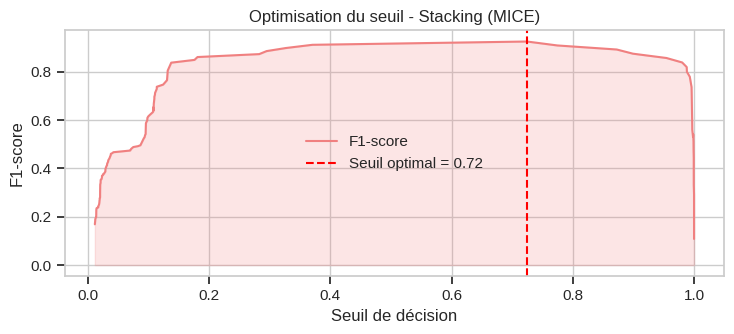


📌 Résultats pour Stacking (MICE)
Seuil optimal : 0.7241
F1-score optimal : 0.9254

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       345
           1       0.97      0.89      0.93        35

    accuracy                           0.99       380
   macro avg       0.98      0.94      0.96       380
weighted avg       0.99      0.99      0.99       380



In [31]:

from modeling.optimize_threshold import optimize_threshold

results = optimize_threshold(
    model=model_mice_retrained,
    X_test=X_test_mice_preprocessed_df[optimal_features_mice],
    y_test=y_test_mice,
    model_name="Stacking",
    dataset_name="MICE",
    figures_dir=paths["FIGURES_MODELING_DIR"],
    json_dir=paths["THRESHOLDS_DIR"]
)


In [ ]:
from modeling.optimize_threshold import load_optimal_threshold

threshold = load_optimal_threshold(
    model_name="Stacking",
    dataset_name="MICE",
    threshold_dir=paths["THRESHOLDS_DIR"]
)


<a name="10-génération-des-prédictions-finales"></a>
# 10. Génération des prédictions finales

Cette dernière section vise à générer les prédictions sur le jeu de données de test (`data_test.csv`) en utilisant le modèle final optimisé.  
Les prédictions sont sauvegardées dans un fichier `my_pred.csv` au format requis pour la soumission.

In [52]:
import pandas as pd
import joblib
import numpy as np
from pathlib import Path
from preprocessing.final_preprocessing import prepare_final_dataset
from modeling.optimize_threshold import load_optimal_threshold

def generate_submission_final_pipeline(
    test_file,
    model_file,
    features_file,
    threshold_dir,
    output_path,
    model_name="stacking",
    dataset_name="mice",
    imputation_method="mice",
    yeojohnson=True,
    remove_outliers=False,
    verbose=True
):
    """
    Génère les prédictions finales pour le challenge STA211 à partir de `data_test.csv`.
    """

    if verbose:
        print("📥 Chargement du fichier test brut...")

    test_file = Path(test_file)

    # 1. Pipeline complet de prétraitement
    if verbose:
        print("⚙️ Application du pipeline de prétraitement...")

    df_test = prepare_final_dataset(
        file_path=test_file,
        strategy='mixed_mar_mcar',
        mar_method=imputation_method,
        drop_outliers=remove_outliers,
        display_info=verbose,
        require_outcome=False,
        save_transformer=False,
        use_comprehensive_correlation=True
    )

    # 2. Chargement des variables sélectionnées
    if verbose:
        print("📌 Chargement des variables sélectionnées...")
    selected_features = joblib.load(features_file)
    X_test = df_test[selected_features]

    # 3. Chargement du modèle entraîné
    if verbose:
        print("🤖 Chargement du modèle...")
    model = joblib.load(model_file)

    # 4. Chargement du seuil optimal (corrigé ici)
    if verbose:
        print(f"🎯 Chargement du seuil optimal depuis : {threshold_dir}")
    optimal_threshold = load_optimal_threshold(
        model_name=model_name,
        dataset_name=dataset_name,
        threshold_dir=threshold_dir
    )
    if optimal_threshold is None:
        raise ValueError("❌ Seuil optimal introuvable.")

    # 5. Prédictions et application du seuil
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= optimal_threshold).astype(int)
    labels = pd.Series(y_pred).map({0: "noad.", 1: "ad."})

    # 6. Sauvegarde du fichier de soumission
    submission_df = pd.DataFrame({
        "id": df_test.index + 1,
        "label": labels
    })

    output_path = Path(output_path)
    submission_df.to_csv(output_path, index=False)

    if verbose:
        print(f"✅ Fichier de soumission enregistré à : {output_path}")
        print("🧾 Aperçu :")
        display(submission_df.head())

    return submission_df


In [54]:
from pathlib import Path
#from submission.generate_submission_pipeline import generate_submission_final_pipeline

# Définir les chemins
test_file = Path("G:/Mon Drive/projet_sta211/data/raw/data_test.csv")
model_file = Path("G:/Mon Drive/projet_sta211/outputs/modeling/models/stacking_mice_reduced.joblib")
features_file = Path("G:/Mon Drive/projet_sta211/outputs/modeling/models/optimal_features_mice_stack.joblib")
threshold_dir = Path("G:/Mon Drive/projet_sta211/outputs/modeling/thresholds")
output_path = Path("G:/Mon Drive/projet_sta211/outputs/submissions/submission_stacking_mice.csv")

# Appel de la fonction
generate_submission_final_pipeline(
    test_file=paths["RAW_DATA_DIR"] / "data_test.csv",
    model_file=paths["MODELS_DIR"] / "stacking_mice_reduced.joblib",
    features_file=paths["MODELS_DIR"] / "optimal_features_mice_stack.joblib",
    threshold_dir=paths["THRESHOLDS_DIR"],
    output_path=paths["ROOT_DIR"] / "my_pred.csv",
    model_name="stacking",
    dataset_name="mice",
    imputation_method="mice",
    yeojohnson=True,
    remove_outliers=True,  # ✅ activation ici avec ou sans outliers
    verbose=True
)




📥 Chargement du fichier test brut...
⚙️ Application du pipeline de prétraitement...
🔄 DÉMARRAGE DU PIPELINE DE PRÉTRAITEMENT (VERSION 3.0)
📂 Étape 1: Chargement des données...

✅ Fichier chargé : /content/drive/MyDrive/projet_sta211/data/raw/data_test.csv
🔢 Dimensions : (820, 1558)
📋 Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
Index: 820 entries, 2460 to 3279
Columns: 1558 entries, X1 to X1558
dtypes: float64(4), int64(1554)
memory usage: 9.8 MB

🔎 Premières lignes :


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X188,X189,X190,X191,X192,X193,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X303,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X381,X382,X383,X384,X385,X386,X387,X388,X389,X390,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400,X401,X402,X403,X404,X405,X406,X407,X408,X409,X410,X411,X412,X413,X414,X415,X416,X417,X418,X419,X420,X421,X422,X423,X424,X425,X426,X427,X428,X429,X430,X431,X432,X433,X434,X435,X436,X437,X438,X439,X440,X441,X442,X443,X444,X445,X446,X447,X448,X449,X450,X451,X452,X453,X454,X455,X456,X457,X458,X459,X460,X461,X462,X463,X464,X465,X466,X467,X468,X469,X470,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480,X481,X482,X483,X484,X485,X486,X487,X488,X489,X490,X491,X492,X493,X494,X495,X496,X497,X498,X499,X500,X501,X502,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512,X513,X514,X515,X516,X517,X518,X519,X520,X521,X522,X523,X524,X525,X526,X527,X528,X529,X530,X531,X532,X533,X534,X535,X536,X537,X538,X539,X540,X541,X542,X543,X544,X545,X546,X547,X548,X549,X550,X551,X552,X553,X554,X555,X556,X557,X558,X559,X560,X561,X562,X563,X564,X565,X566,X567,X568,X569,X570,X571,X572,X573,X574,X575,X576,X577,X578,X579,X580,X581,X582,X583,X584,X585,X586,X587,X588,X589,X590,X591,X592,X593,X594,X595,X596,X597,X598,X599,X600,X601,X602,X603,X604,X605,X606,X607,X608,X609,X610,X611,X612,X613,X614,X615,X616,X617,X618,X619,X620,X621,X622,X623,X624,X625,X626,X627,X628,X629,X630,X631,X632,X633,X634,X635,X636,X637,X638,X639,X640,X641,X642,X643,X644,X645,X646,X647,X648,X649,X650,X651,X652,X653,X654,X655,X656,X657,X658,X659,X660,X661,X662,X663,X664,X665,X666,X667,X668,X669,X670,X671,X672,X673,X674,X675,X676,X677,X678,X679,X680,X681,X682,X683,X684,X685,X686,X687,X688,X689,X690,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700,X701,X702,X703,X704,X705,X706,X707,X708,X709,X710,X711,X712,X713,X714,X715,X716,X717,X718,X719,X720,X721,X722,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732,X733,X734,X735,X736,X737,X738,X739,X740,X741,X742,X743,X744,X745,X746,X747,X748,X749,X750,X751,X752,X753,X754,X755,X756,X757,X758,X759,X760,X761,X762,X763,X764,X765,X766,X767,X768,X769,X770,X771,X772,X773,X774,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784,X785,X786,X787,X788,X789,X790,X791,X792,X793,X794,X795,X796,X797,X798,X799,X800,X801,X802,X803,X804,X805,X806,X807,X808,X809,X810,X811,X812,X813,X814,X815,X816,X817,X818,X819,X820,X821,X8

✅ Après chargement: X4 présente et correcte (valeurs: [np.float64(0.0), np.float64(1.0)])

🔧 Étape 2: Conversion de X4...
✅ Colonne 'X4' convertie en Int64 (binaire).
✅ Après conversion X4: X4 présente et correcte (valeurs: [np.int64(0), np.int64(1)])

🔄 Étape 3: Transformation Yeo-Johnson (X1, X2, X3)...
✅ Après Yeo-Johnson: X4 présente et correcte (valeurs: [np.int64(0), np.int64(1)])

🔧 Étape 4: Imputation des valeurs manquantes (mice)...
🔧 Début de l'imputation des valeurs manquantes
📊 Valeurs manquantes initiales: 692
📊 Variables MAR à imputer: 3
   • Total valeurs manquantes: 688
   • X1_trans: 229 valeurs manquantes
   • X2_trans: 228 valeurs manquantes
   • X3_trans: 231 valeurs manquantes
✅ Imputation mice appliquée sur 3 colonnes MAR
✅ X4: 4 valeurs imputées par médiane (1.0000)

📊 Résumé de l'imputation:
   • Valeurs manquantes avant: 692
   • Valeurs manquantes après: 0
   • Valeurs imputées: 692
✅ Imputation terminée avec succès
✅ Après imputation: X4 présente et correcte 

,id,label
0,2461,ad.
1,2462,ad.
2,2463,ad.
3,2464,ad.
4,2465,ad.


,id,label
0,2461,ad.
1,2462,ad.
2,2463,ad.
3,2464,ad.
4,2465,ad.
...,...,...
815,3276,ad.
816,3277,ad.
817,3278,ad.
818,3279,ad.


<a name="conclusion"></a>
# 11. Conclusion
